# Train 1D CNN

1D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

- Three-way SoftMax classifier of normal, non-vascular MCI, and non-vascular dementia

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from tqdm.auto import tqdm

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional

# custom package
from utils.eeg_dataset import *

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 1.9.0
cuda is available.


In [5]:
# Data file path
root_path = r'dataset/02_Curated_Segment_Data/'

In [6]:
meta_path = os.path.join(root_path, 'metadata_debug.json')
with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'], [0, 'New Montage - Montage 002']],
 'label': ['mci', 'mci_amnestic', 'mci_amnestic_rf'],
 'record': '2018-10-26T15:46:26',
 'serial': '00001'}


-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]

def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')

class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = c
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 10692 data belonging to Normal
- There are 9375 data belonging to Non-vascular MCI
- There are 6326 data belonging to Non-vascular dementia


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)

    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[m['class_label']] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[m['class_label']] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[m['class_label']] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 21115
Validation data size	: 2640
Test data size		: 2638

 --- Recheck --- 

Train data label distribution	: [8554 7500 5061] 21115
Val data label distribution	: [1069  938  633] 2640
Test data label distribution	: [1069  937  632] 2638


In [10]:
print('=' * 50, 'TRAIN', '=' * 50)
for m in metadata_train:
    if m['edfname'] == '00649687_010715':
        print(m['serial'])

print('=' * 50, 'VALIDATION', '=' * 50)
for m in metadata_val:
    if m['edfname'] == '00649687_010715':
        print(m['serial'])

print('=' * 50, 'TEST', '=' * 50)
for m in metadata_test:
    if m['edfname'] == '00649687_010715':
        print(m['serial'])

================================================== TRAIN ==================================================
06880
06890
06888
06900
06878
06889
06902
06883
06893
06904
06892
06876
06885
06897
06895
06877
06899
06884
06896
================================================== VALIDATION ==================================================
06875
06887
06886
06891
06894
================================================== TEST ==================================================
06901
06881
06903
06898
06882
06879


#### Wrap the splitted data using PyTorch Dataset

In [11]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
70.73961638645513 9.520262451914755


In [12]:
composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGRandomCrop(crop_length=round(200*10)), # 10s
                               EEGNormalizePerSignal(),
                               EEGToTensor()])

train_dataset = EEGDataset(root_path, metadata_train, composed)
val_dataset = EEGDataset(root_path, metadata_val, composed)
test_dataset = EEGDataset(root_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print(train_dataset[0])

print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)
print(val_dataset[0])

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)
print(test_dataset[0])

torch.Size([20, 2000])
{'signal': tensor([[-0.2619, -0.1045,  0.0529,  ..., -0.5768, -0.4981, -0.4981],
        [-0.3087, -0.4230, -0.4230,  ...,  0.2628,  0.2628,  0.1485],
        [-0.9100, -1.0570, -1.2041,  ..., -0.4688, -0.4688, -0.7629],
        ...,
        [ 0.4822,  0.7521,  0.7521,  ..., -0.9569, -0.9569, -1.0468],
        [-0.7351, -0.7351, -0.7351,  ..., -0.2604, -0.4977, -0.4977],
        [-0.2585, -0.2841, -0.2713,  ...,  0.2928,  0.3441,  0.3697]]), 'age': tensor(-0.1827), 'class_label': tensor(2), 'metadata': {'serial': '15898', 'edfname': '00906868_040116', 'birth': '1946-04-09', 'record': '2016-01-04T11:46:11', 'age': 69, 'dx1': 'load', 'label': ['dementia', 'ad', 'load'], 'events': [[1218, 'Photic Off'], [2352, 'sleep']], 'class_type': 'Non-vascular dementia', 'class_label': 2}}

----------------------------------------------------------------------------------------------------

torch.Size([20, 2000])
{'signal': tensor([[-0.1840, -0.2063, -0.2287,  ...,  0.1791,  0.

#### Data loader test

In [13]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

Current PyTorch device: cuda
0 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
1 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
2 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
3 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
4 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32


#### Train, validation, test dataloaders

In [14]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Some useful functions for training

In [15]:
from torch.utils.tensorboard import SummaryWriter
import ipynbname
nb_fname = ipynbname.name()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

In [16]:
def train_one_epoch(model, optimizer, log_interval):
    # turn the models to training mode
    model.train()
    losses = []
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    train_confusion = np.zeros((C, C), dtype=np.int32)
    
    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)
        
        # apply model on whole batch directly on device
        output = model(x, age)

        # negative log-likelihood for a tensor of size (batch x n_output)
        pred = F.log_softmax(output, dim=1)
        loss = F.nll_loss(pred, target)
        
        # backprop and update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # record loss
        losses.append(loss.item())

        # train accuracy
        pred = pred.argmax(dim=-1)
        correct += pred.squeeze().eq(target).sum().item()
        total += pred.shape[0]
        
        # confusion matrix
        train_confusion += calculate_confusion_matrix(pred, target)

        # print training stats
        if log_interval is not None and (batch_i + 1) % log_interval == 0:
            print(f'- Iter {batch_i + 1:03d} / {len(train_loader):03d}, Loss: {loss.item():.06f}')
    
    train_accuracy = 100.0 * correct / total
    return (losses, train_accuracy, train_confusion)


def check_val_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
        
    C = len(class_label_to_type)
    val_confusion = np.zeros((C, C), dtype=np.int32)
    
    for k in range(repeat):
        for sample_batched in val_loader:
            # pull up the data
            x = sample_batched['signal'].to(device)
            age = sample_batched['age'].to(device)
            target = sample_batched['class_label'].to(device)

            # apply model on whole batch directly on device
            output = model(x, age)
            pred = F.log_softmax(output, dim=1)

            # val accuracy
            pred = pred.argmax(dim=-1)
            correct += pred.squeeze().eq(target).sum().item()
            total += pred.shape[0]
            
            # confusion matrix
            val_confusion += calculate_confusion_matrix(pred, target)
            
    val_accuracy = 100.0 * correct / total
    return (val_accuracy, val_confusion)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    test_confusion = np.zeros((C, C), dtype=np.int32)
    
    test_debug = {data['metadata']['serial']: 
                  {'GT': data['class_label'].item(), 
                   'Acc': 0, 
                   'Pred': [0] * C} for data in test_dataset}
        
    for k in range(repeat):
        for sample_batched in test_loader:
            # pull up the data
            x = sample_batched['signal'].to(device)
            age = sample_batched['age'].to(device)
            target = sample_batched['class_label'].to(device)

            # apply model on whole batch directly on device
            output = model(x, age)
            pred = F.log_softmax(output, dim=1)
            
            # test accuracy
            pred = pred.argmax(dim=-1)
            correct += pred.squeeze().eq(target).sum().item()
            total += pred.shape[0]
            
            # confusion matrix
            test_confusion += calculate_confusion_matrix(pred, target)
            
            # test debug
            for n in range(pred.shape[0]):
                serial = sample_batched['metadata'][n]['serial']
                test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                test_debug[serial]['Pred'][pred[n].item()] += 1
                acc = test_debug[serial]['Pred'][target[n].item()] / np.sum(test_debug[serial]['Pred']) * 100
                test_debug[serial]['Acc'] = f'{acc:>6.02f}%'
        
    test_accuracy = 100.0 * correct / total
    return (test_accuracy, test_confusion, test_debug)


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    C = len(class_label_to_type)
    confusion = np.zeros((C, C), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [17]:
def draw_loss_plot(loss_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(loss_history)
    
    ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)    
    for e in range(1, n_epoch + 1):
        
        if e % lr_schedule_step == 0:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='m', alpha=0.3)
        else:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)
    
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_accuracy_history(train_acc_history, val_acc_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_acc_history, 'r-', label='Train accuracy')
    ax.plot(val_acc_history, 'b-', label='Validation accuracy')
    ax.legend(loc='lower right')
    
    ax.set_title('Accuracy Plot during Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_confusion(confusion):
    C = len(class_label_to_type)
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(5.0, 5.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(confusion, alpha=0.8)

    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_label_to_type)
    ax.set_yticklabels(class_label_to_type)
    
    for r in range(C):
        for c in range(C):
            text = ax.text(c, r, confusion[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [18]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, epochs):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

        for e in range(epochs):
            _, train_accuracy, _ = train_one_epoch(model, optimizer, log_interval=None)
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, train_accuracy))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, figsize=(8.0, 8.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy')
    
    for log_lr, val_accuracy in learning_rate_record:
        ax.scatter(log_lr, val_accuracy, c='r',
                   alpha=0.5, edgecolors='none')
    
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Train 1D CNN models

#### 1D CNN: Tiny model

In [19]:
class TinyNet(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=7, n_channel=64, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=35, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel, n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [20]:
model = TinyNet(n_input=train_dataset[0]['signal'].shape[0], 
                n_output=3, 
                use_age=True, 
                final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'TinyNet')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

TinyNet(
  (conv1): Conv1d(20, 64, kernel_size=(35,), stride=(7,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (final_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=65, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bnfc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)



C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Shape right before squeezing: torch.Size([32, 64, 32])
The Number of parameters of the model: 78,403


  0%|          | 0/300 [00:00<?, ?it/s]

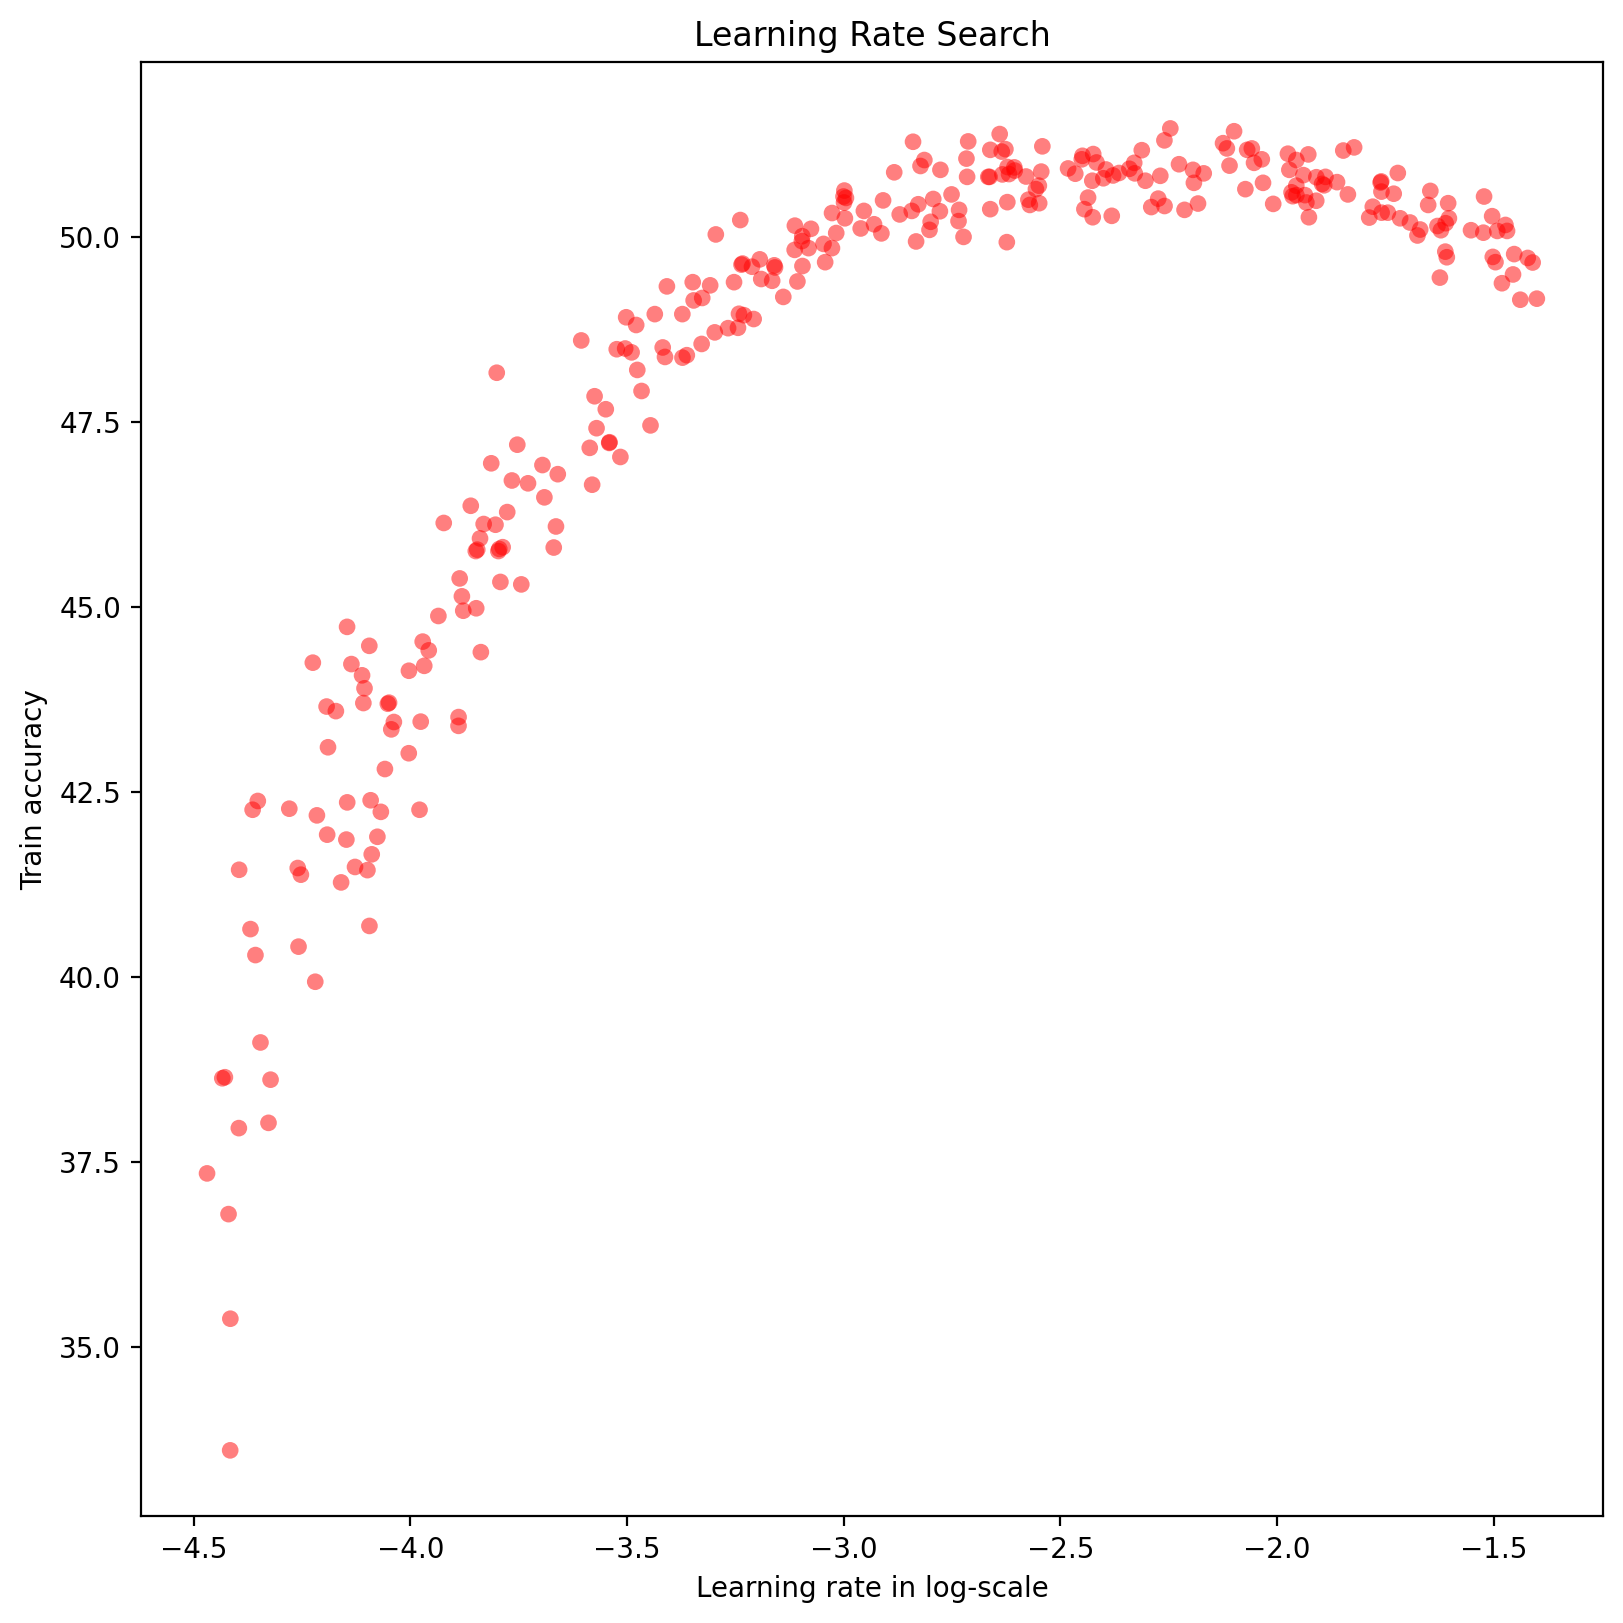

best_log_lr: -2.2460725429905124


In [21]:
record = learning_rate_search(model, 
                              min_log_lr=-4.5, 
                              max_log_lr=-1.4, 
                              trials=300, 
                              epochs=1)
draw_learning_rate_record(record)
best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

# best_log_lr = -1.9358023684588126
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/200 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 200, Learning rate: 5.67e-03 ------------------------------
- Iter 131 / 659, Loss: 1.057006
- Iter 262 / 659, Loss: 0.866612
- Iter 393 / 659, Loss: 0.992000
- Iter 524 / 659, Loss: 0.946283
- Iter 655 / 659, Loss: 0.818141

* Train accuracy / confusion: 51.12% / [[5753, 2248, 542], [2639, 3582, 1268], [1194, 2417, 1445]], 
* Val   accuracy / confusion: 54.85% / [[680, 333, 56], [227, 570, 141], [96, 339, 198]]

------------------------------ Epoch 002 / 200, Learning rate: 5.67e-03 ------------------------------
- Iter 131 / 659, Loss: 0.906525
- Iter 262 / 659, Loss: 0.936121
- Iter 393 / 659, Loss: 1.043894
- Iter 524 / 659, Loss: 0.916649
- Iter 655 / 659, Loss: 0.863549

* Train accuracy / confusion: 54.72% / [[5827, 2282, 435], [2441, 3828, 1222], [871, 2297, 1885]], 
* Val   accuracy / confusion: 55.30% / [[822, 234, 13], [344, 519, 75], [132, 382, 119]]

------------------------------ Epoch 003 / 200, Learning rate: 5.67e-03 ---------

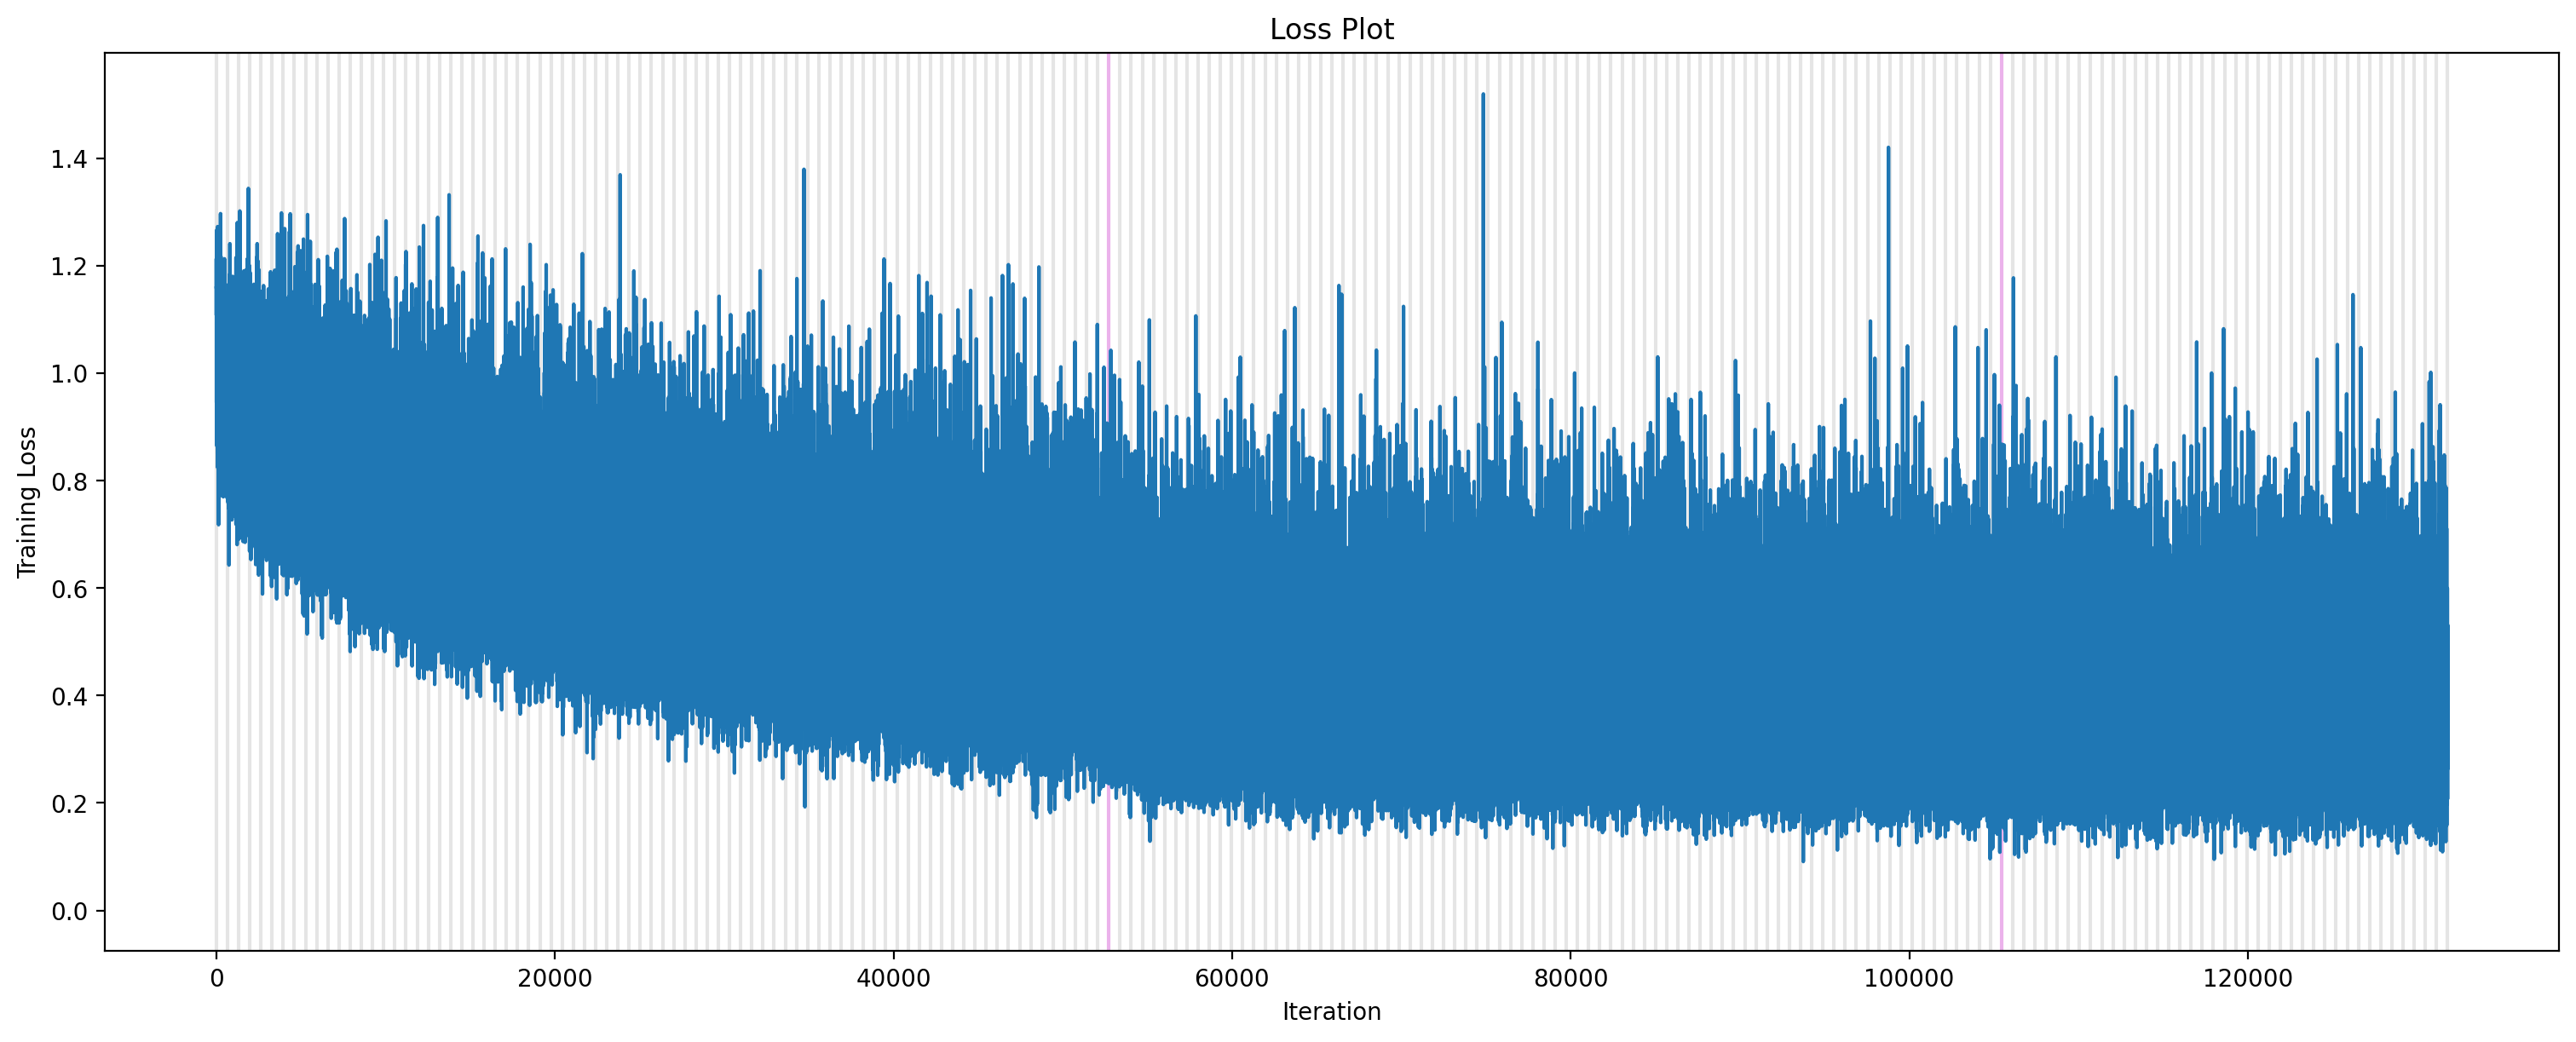

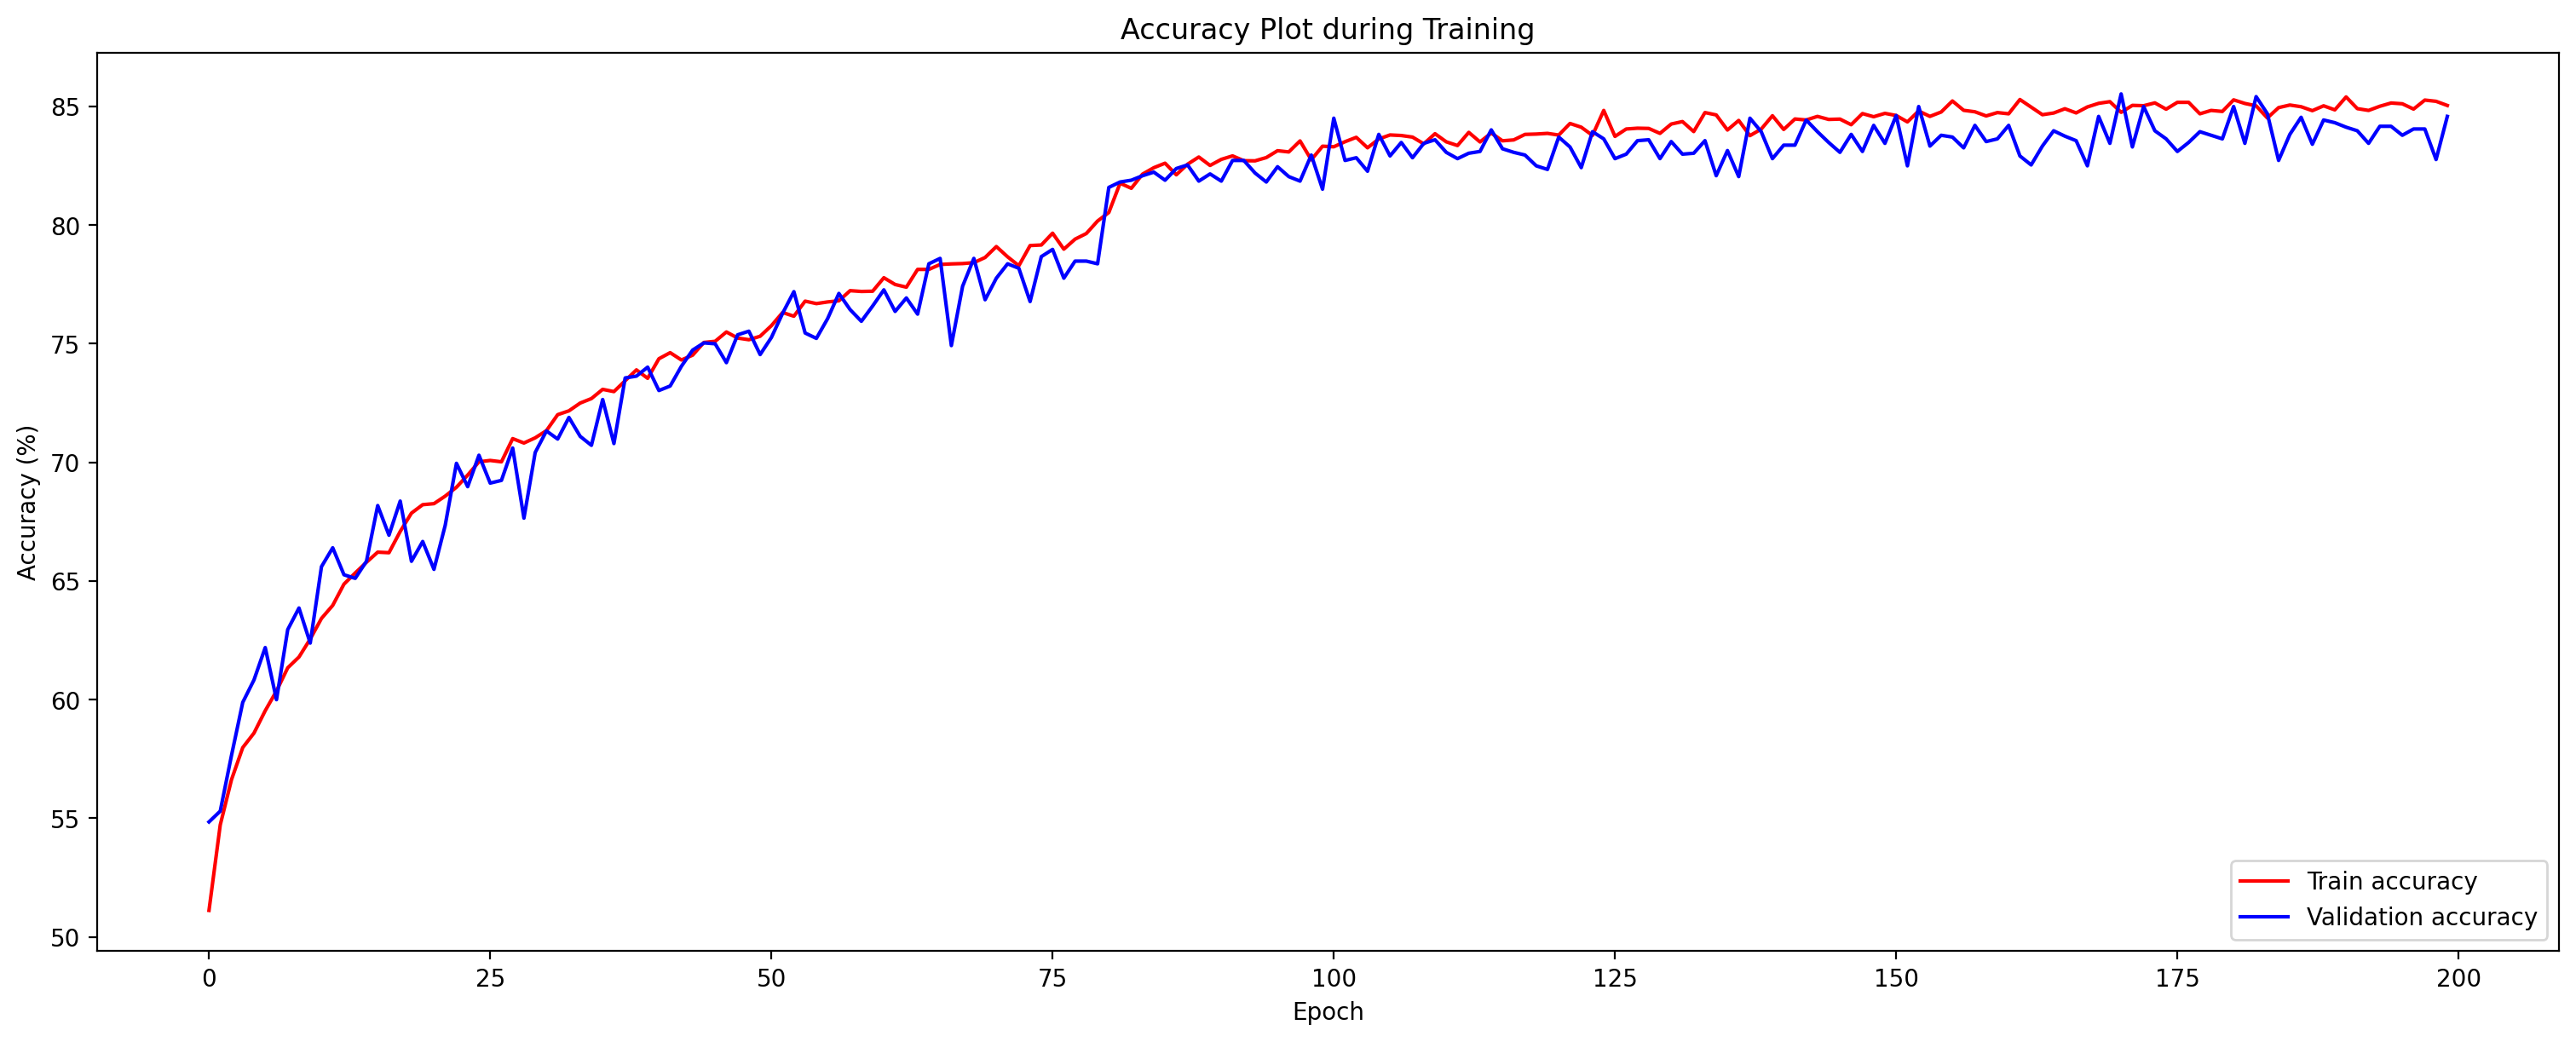

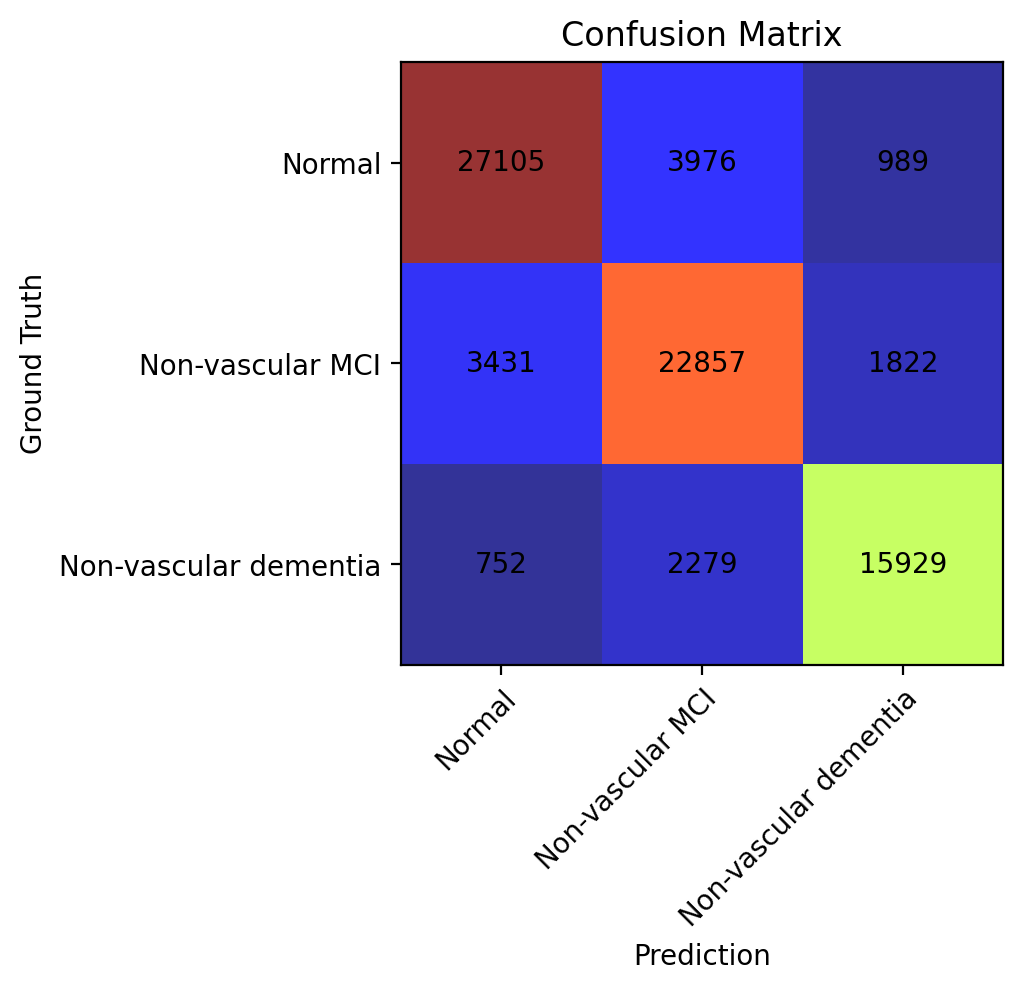

In [22]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 200
lr_schedule_step = 80
log_interval = len(train_loader) // 5

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [23]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

- Debug table:
{ '14546': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00865039_170816'},
  '00719': {'GT': 1, 'Acc': ' 90.00%', 'Pred': [1, 27, 2], 'edfname': '00164098_041214'},
  '30664': {'GT': 1, 'Acc': ' 46.67%', 'Pred': [0, 14, 16], 'edfname': '01303196_020317'},
  '04086': {'GT': 0, 'Acc': ' 96.67%', 'Pred': [29, 1, 0], 'edfname': '00498791_260916'},
  '05765': {'GT': 2, 'Acc': ' 60.00%', 'Pred': [2, 10, 18], 'edfname': '00623681_070415'},
  '19208': {'GT': 1, 'Acc': ' 96.67%', 'Pred': [0, 29, 1], 'edfname': '01008809_021017'},
  '19516': {'GT': 2, 'Acc': '100.00%', 'Pred': [0, 0, 30], 'edfname': '01019016_241115'},
  '36174': {'GT': 1, 'Acc': ' 86.67%', 'Pred': [4, 26, 0], 'edfname': '01430323_060819'},
  '12726': {'GT': 1, 'Acc': ' 76.67%', 'Pred': [0, 23, 7], 'edfname': '00796686_020819'},
  '31736': {'GT': 0, 'Acc': ' 83.33%', 'Pred': [25, 5, 0], 'edfname': '01324136_201217'},
  '07979': {'GT': 1, 'Acc': ' 90.00%', 'Pred': [0, 27, 3], 'edfname': '00673505_020

#### 1D CNN: M5-like model

In [24]:
class M5(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=4, n_channel=256, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=41, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=11)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=11)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(2)
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
    
        if self.use_age:        
            self.fc1 = nn.Linear(2 * n_channel + 1, 2 * n_channel)
        else:
            self.fc1 = nn.Linear(2 * n_channel, 2 * n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(2 * n_channel)
        self.fc2 = nn.Linear(2 * n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
    
        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [25]:
model = M5(n_input=train_dataset[0]['signal'].shape[0], 
           n_output=3, 
           use_age=True, 
           final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'M5-like')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

M5(
  (conv1): Conv1d(20, 256, kernel_size=(41,), stride=(2,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(11,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(11,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(512, 512, kernel_size=(11,), stride

  0%|          | 0/300 [00:00<?, ?it/s]

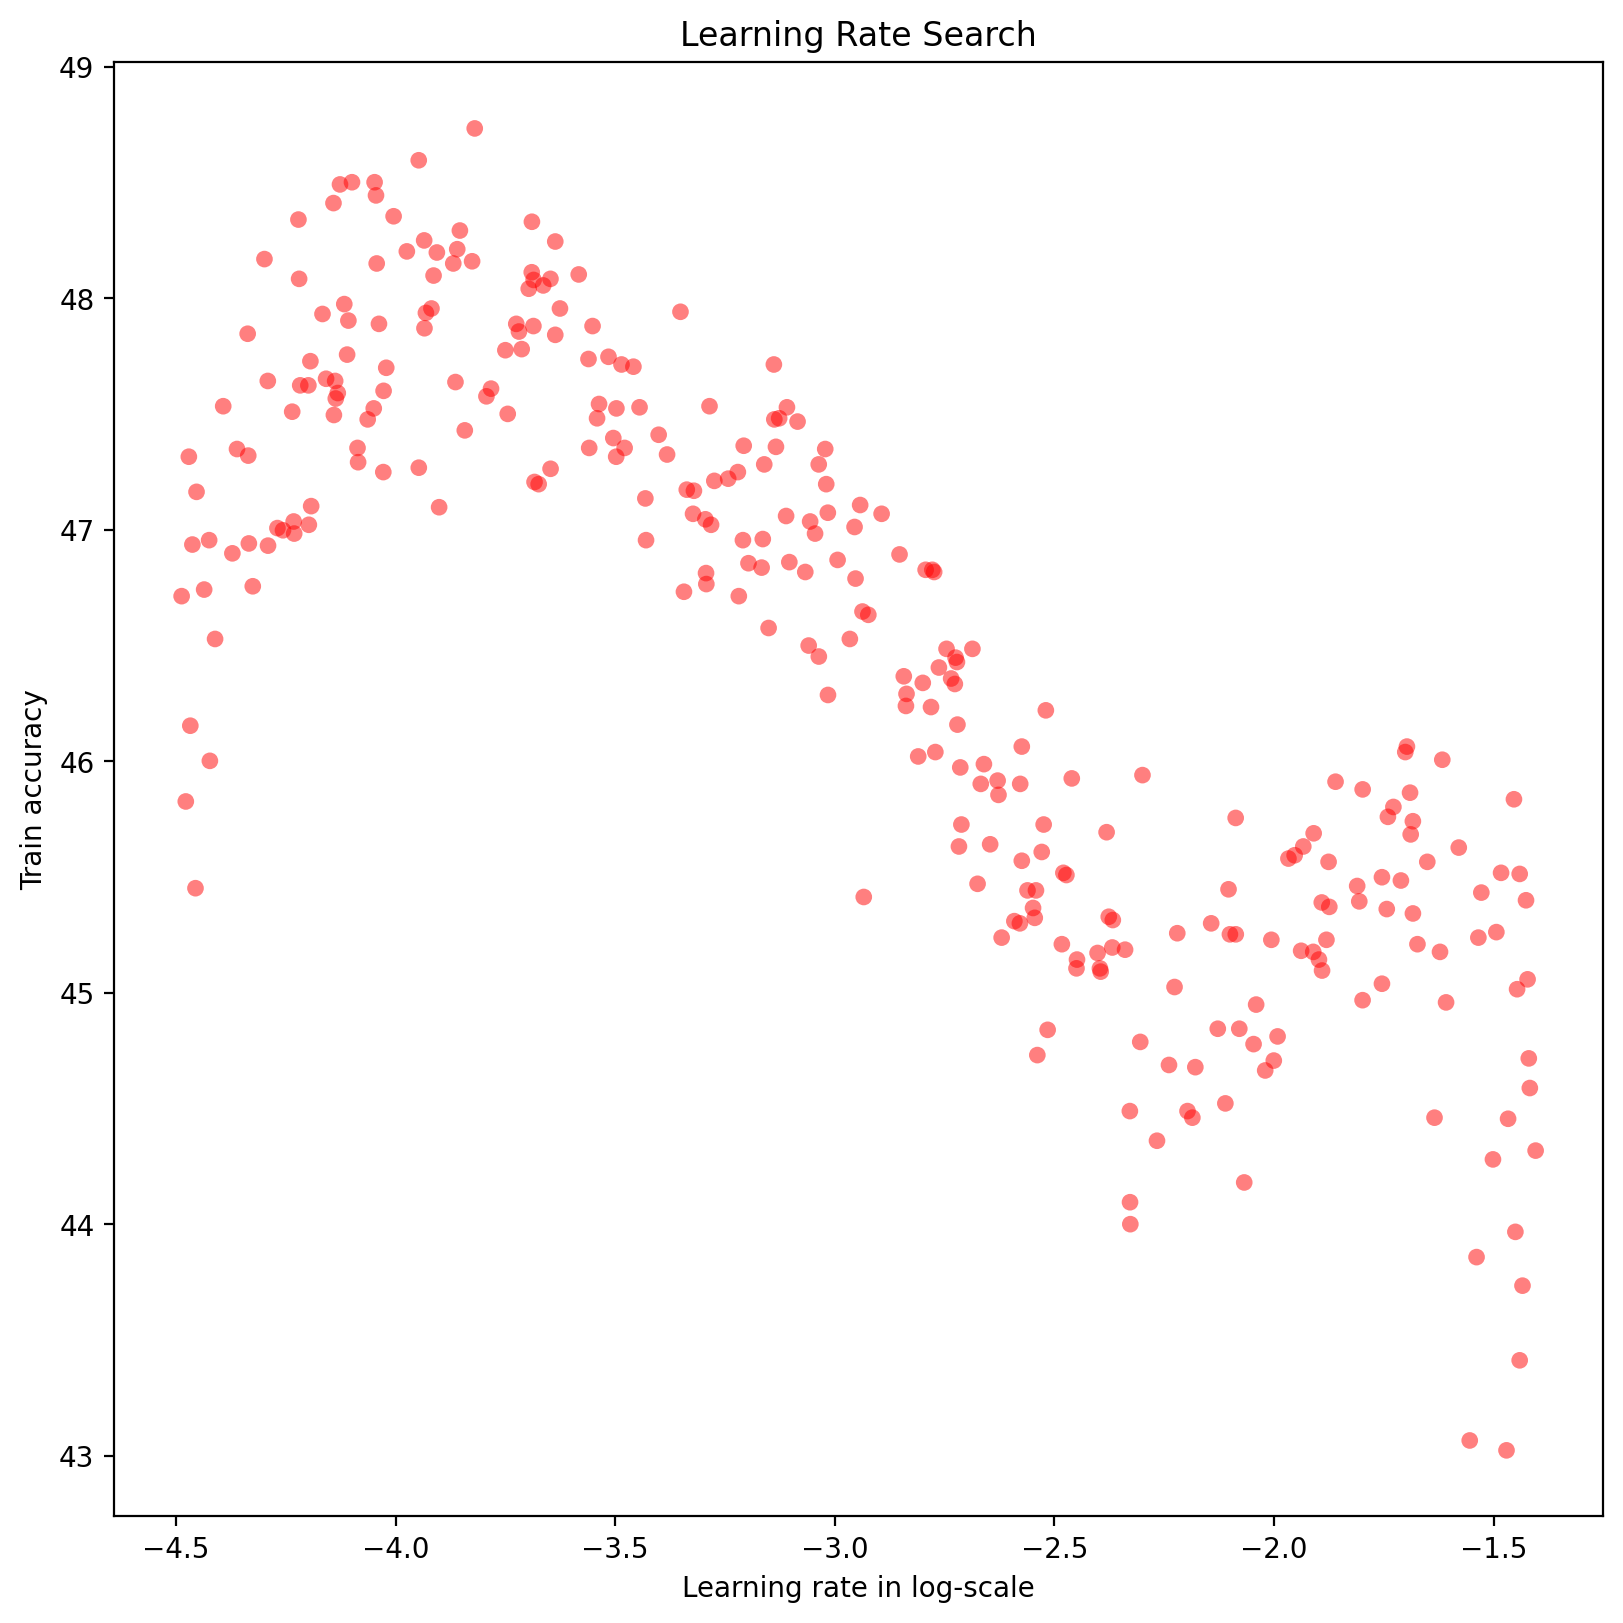

best_log_lr: -3.8199400106221946


In [26]:
record = learning_rate_search(model, 
                              min_log_lr=-4.5, 
                              max_log_lr=-1.4, 
                              trials=300, 
                              epochs=1)
draw_learning_rate_record(record)
best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

# best_log_lr = -3.1867127146006564
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/200 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 200, Learning rate: 1.51e-04 ------------------------------
- Iter 131 / 659, Loss: 1.048958
- Iter 262 / 659, Loss: 0.972625
- Iter 393 / 659, Loss: 0.956385
- Iter 524 / 659, Loss: 0.973586
- Iter 655 / 659, Loss: 0.928608

* Train accuracy / confusion: 47.39% / [[5592, 2174, 778], [3105, 3000, 1386], [1527, 2124, 1402]], 
* Val   accuracy / confusion: 53.56% / [[788, 188, 93], [342, 400, 196], [142, 265, 226]]

------------------------------ Epoch 002 / 200, Learning rate: 1.51e-04 ------------------------------
- Iter 131 / 659, Loss: 0.790763
- Iter 262 / 659, Loss: 1.041320
- Iter 393 / 659, Loss: 1.003729
- Iter 524 / 659, Loss: 0.882439
- Iter 655 / 659, Loss: 0.845801

* Train accuracy / confusion: 53.63% / [[6097, 1893, 555], [2725, 3306, 1459], [1118, 2028, 1907]], 
* Val   accuracy / confusion: 55.64% / [[660, 359, 50], [200, 611, 127], [80, 355, 198]]

------------------------------ Epoch 003 / 200, Learning rate: 1.51e-04 -------

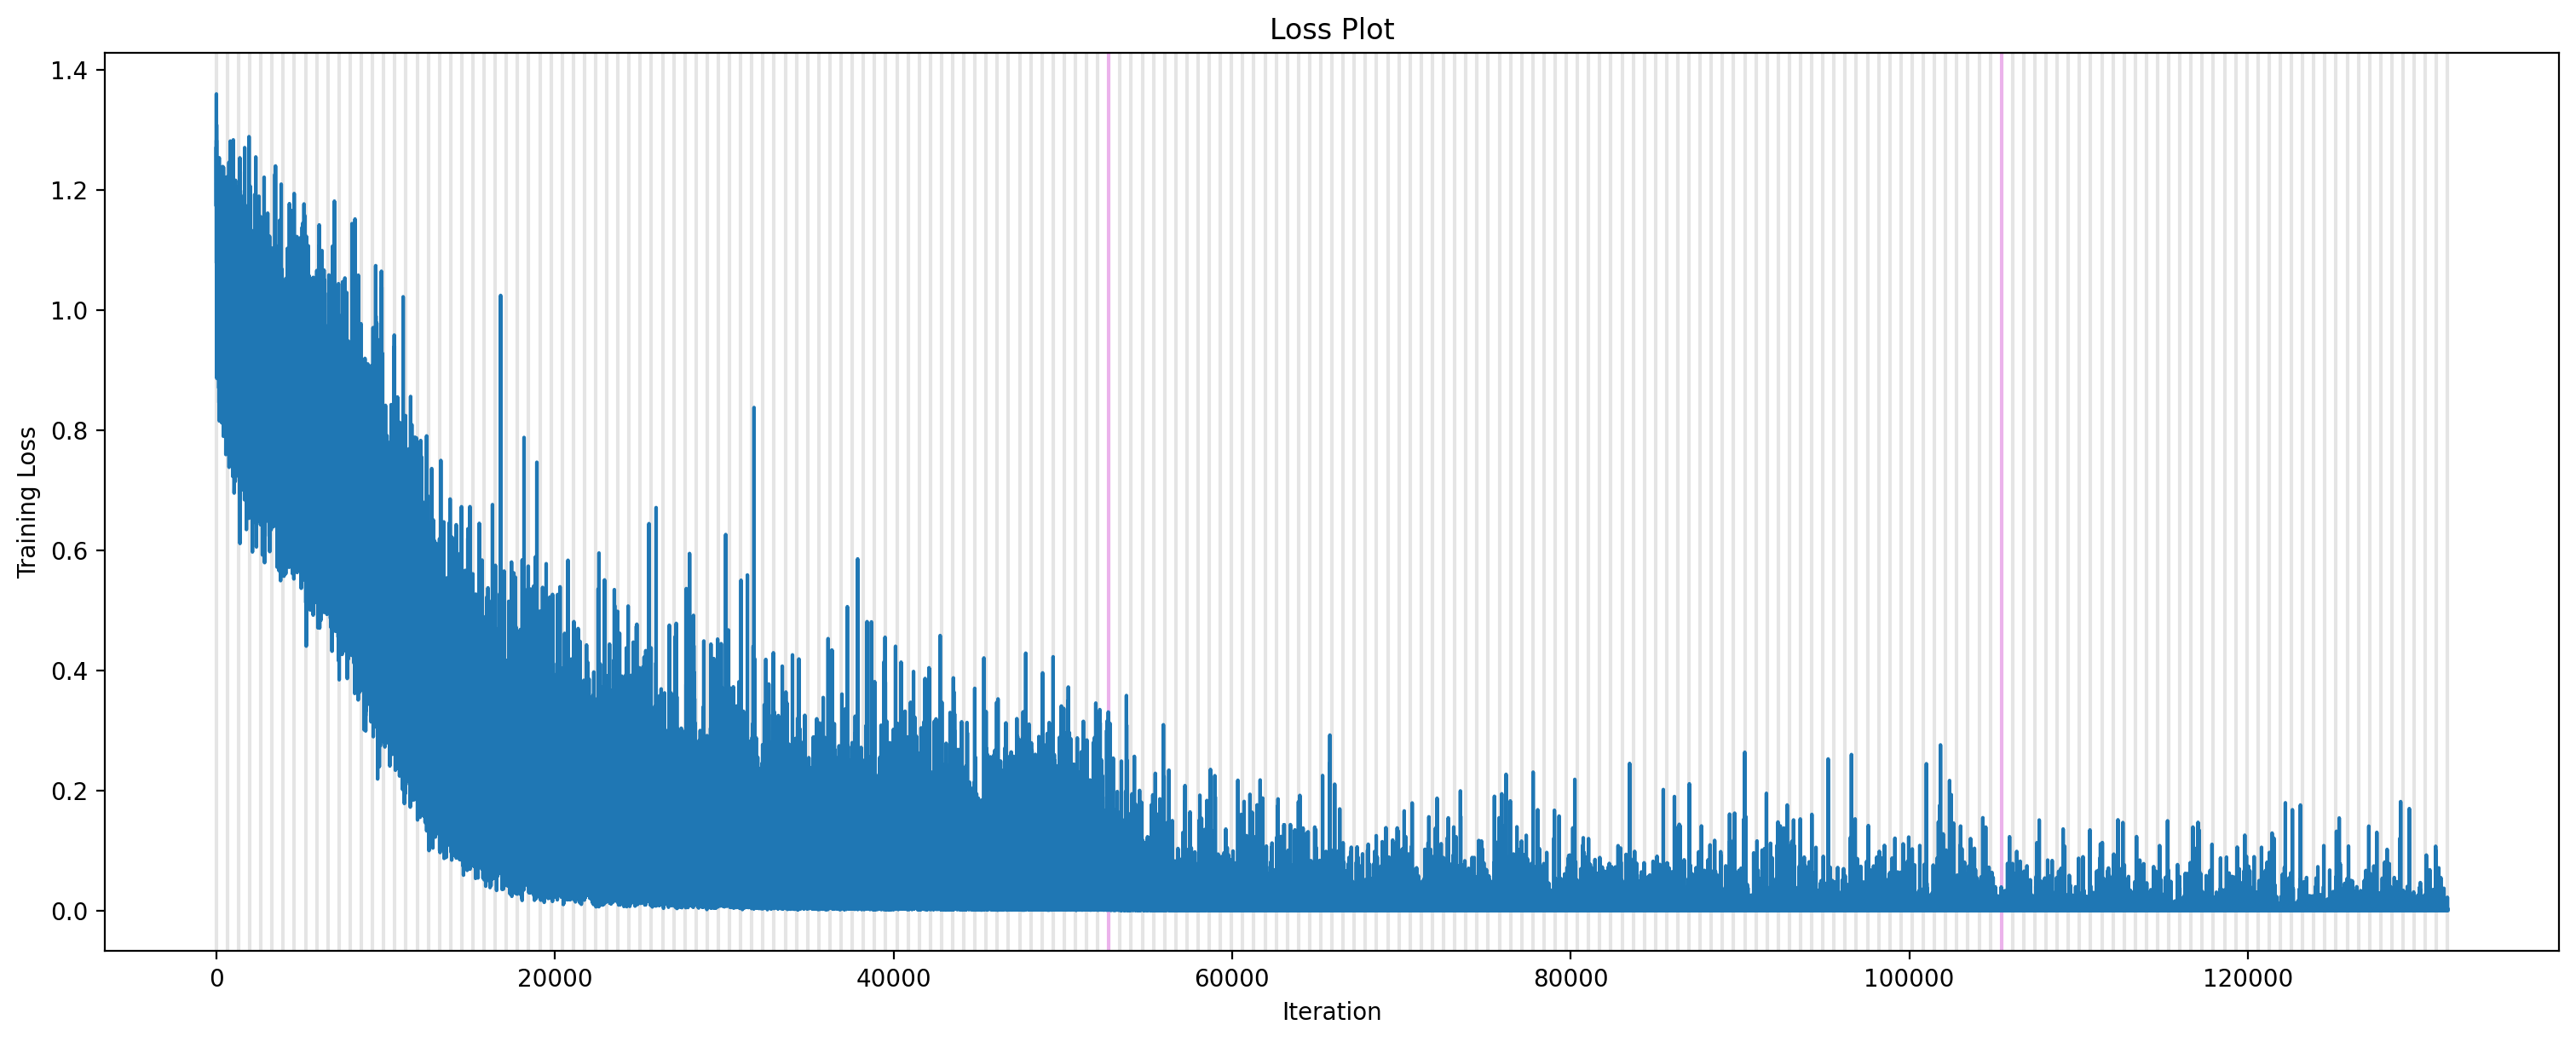

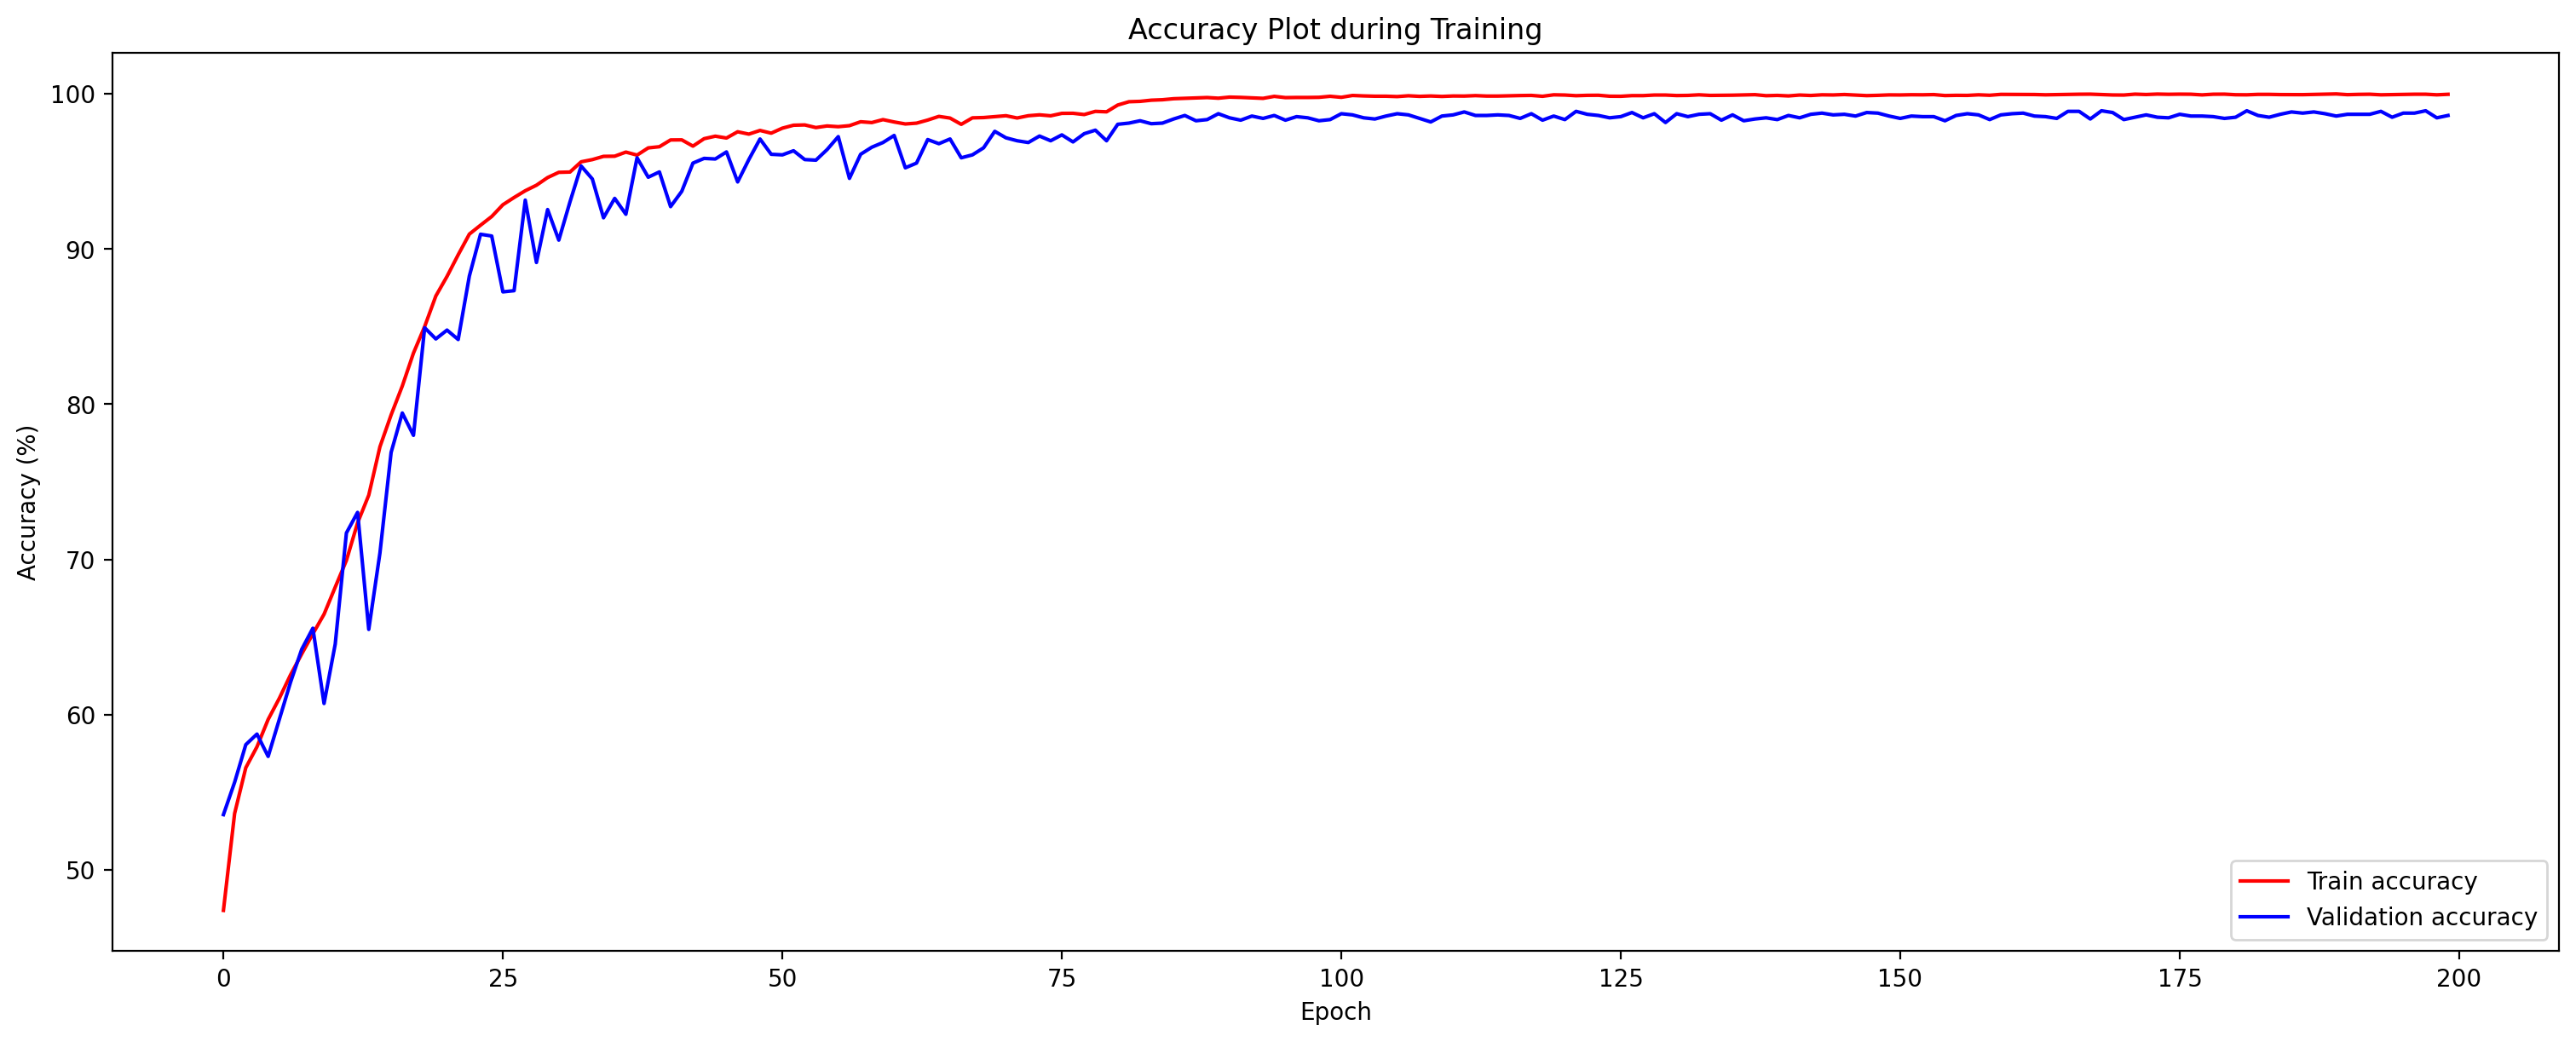

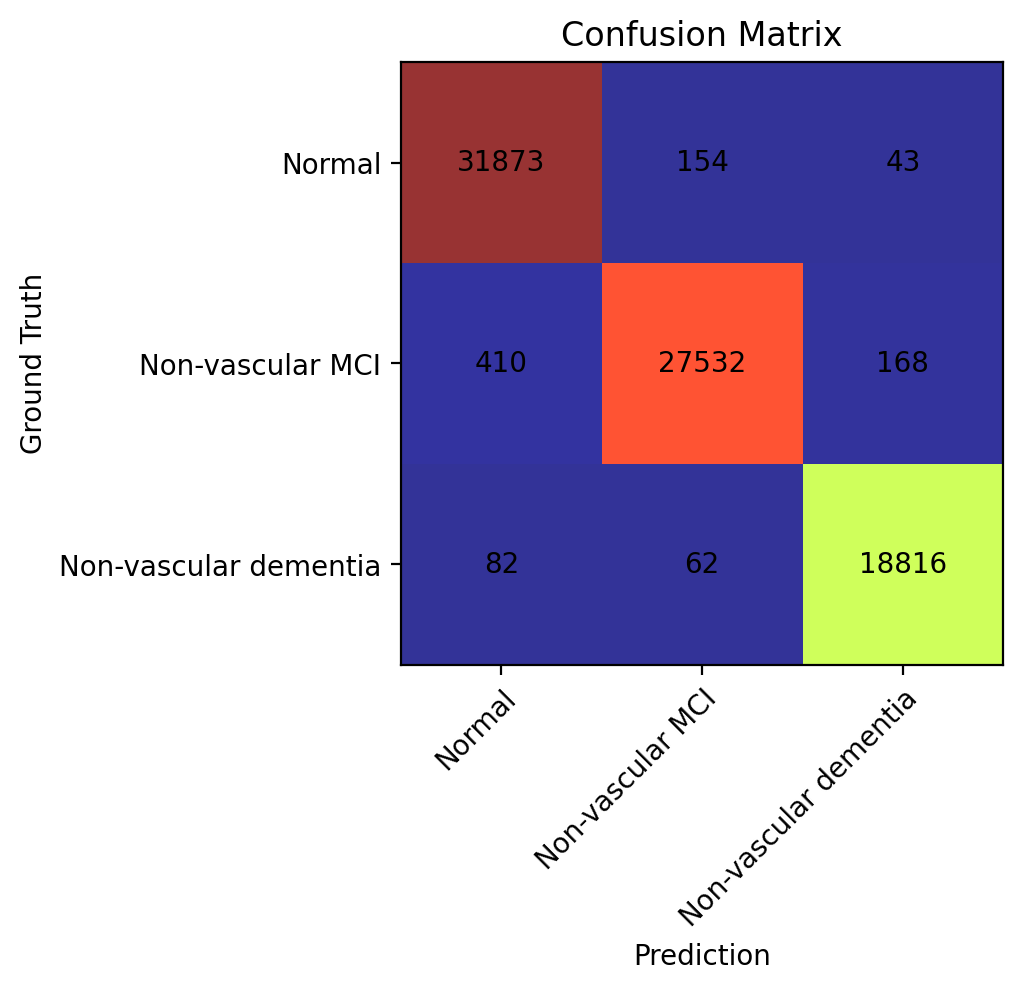

In [27]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 200
lr_schedule_step = 80
log_interval = len(train_loader) // 5

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [28]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

- Debug table:
{ '14546': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00865039_170816'},
  '00719': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00164098_041214'},
  '30664': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01303196_020317'},
  '04086': {'GT': 0, 'Acc': '100.00%', 'Pred': [30, 0, 0], 'edfname': '00498791_260916'},
  '05765': {'GT': 2, 'Acc': ' 96.67%', 'Pred': [0, 1, 29], 'edfname': '00623681_070415'},
  '19208': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01008809_021017'},
  '19516': {'GT': 2, 'Acc': '100.00%', 'Pred': [0, 0, 30], 'edfname': '01019016_241115'},
  '36174': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01430323_060819'},
  '12726': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00796686_020819'},
  '31736': {'GT': 0, 'Acc': '100.00%', 'Pred': [30, 0, 0], 'edfname': '01324136_201217'},
  '07979': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00673505_02041

#### 1D CNN: ResNet-like model

In [19]:
class BasicResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(c_out)

        self.conv2 = nn.Conv1d(in_channels=c_out, out_channels=c_out, 
                               kernel_size=kernel_size, stride=1, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out)

        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        
        return x

In [20]:
class BottleneckBlock(nn.Module):
    expansion: int = 4
        
    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        width = c_out
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=width, 
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(width)

        self.conv2 = nn.Conv1d(in_channels=width, out_channels=width, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(width)

        self.conv3 = nn.Conv1d(in_channels=width, out_channels=c_out*self.expansion, 
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm1d(c_out*self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out*self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out*self.expansion, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out*self.expansion)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        x = self.relu(x + identity)
        
        return x

In [21]:
class ResNet(nn.Module):
    def __init__(self, 
                 block: Type[Union[BasicResBlock, BottleneckBlock]], 
                 conv_layers: List[int],
                 n_fc: int,
                 n_input=20,
                 n_output=3,
                 n_start=64,
                 kernel_size=9, 
                 use_age=True, 
                 final_pool='average') -> None:
        
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")        

        self.c_current = n_start
        self.use_age = use_age
        
        self.input_stage = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=n_start, 
                      kernel_size=kernel_size*3, stride=2,
                      padding=(kernel_size*3)//2, bias=False),
            nn.BatchNorm1d(n_start), 
            nn.ReLU(),
        )
        
        self.conv_stage1 = self._make_conv_layer(block, conv_layers[0], n_start, kernel_size, stride=3)
        self.conv_stage2 = self._make_conv_layer(block, conv_layers[1], n_start*2, kernel_size, stride=3)
        self.conv_stage3 = self._make_conv_layer(block, conv_layers[2], n_start*4, kernel_size, stride=3)
        self.conv_stage4 = self._make_conv_layer(block, conv_layers[3], n_start*8, kernel_size, stride=3)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        fc_layers = []        
        if self.use_age:
            self.c_current = self.c_current + 1
        
        for l in range(n_fc):
            layer = nn.Sequential(nn.Linear(self.c_current, self.c_current // 2, bias=False),
                                  nn.Dropout(p=0.1),
                                  nn.BatchNorm1d(self.c_current // 2), 
                                  nn.ReLU())
            self.c_current = self.c_current // 2
            fc_layers.append(layer)
        fc_layers.append(nn.Linear(self.c_current, n_output))
        self.fc_stage = nn.Sequential(*fc_layers)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
        
    def _make_conv_layer(self, block: Type[Union[BasicResBlock, BottleneckBlock]], 
                         n_block: int, c_out: int, kernel_size: int, stride: int = 1) -> nn.Sequential:
        layers = []
        c_in = self.c_current
        layers.append(block(c_in, c_out, kernel_size, stride=1))

        c_in = c_out * block.expansion
        self.c_current = c_in
        for _ in range(1, n_block):
            layers.append(block(c_in, c_out, kernel_size, stride=1))
            
        layers.append(nn.MaxPool1d(kernel_size=stride))
            
        return nn.Sequential(*layers)

    def forward(self, x, age, print_shape=False):
        x = self.input_stage(x)
        
        x = self.conv_stage1(x)
        x = self.conv_stage2(x)
        x = self.conv_stage3(x)
        x = self.conv_stage4(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
                
        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)
        x = self.fc_stage(x)
        
        return x
        # return F.log_softmax(x, dim=2)

In [32]:
model = ResNet(block=BottleneckBlock, 
               conv_layers=[2, 2, 2, 2], 
               n_fc=3, 
               n_input=train_dataset[0]['signal'].shape[0], 
               n_output=3, 
               n_start=64,
               kernel_size=9, 
               use_age=True, 
               final_pool='max')
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'ResNet-like')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tru

  0%|          | 0/300 [00:00<?, ?it/s]

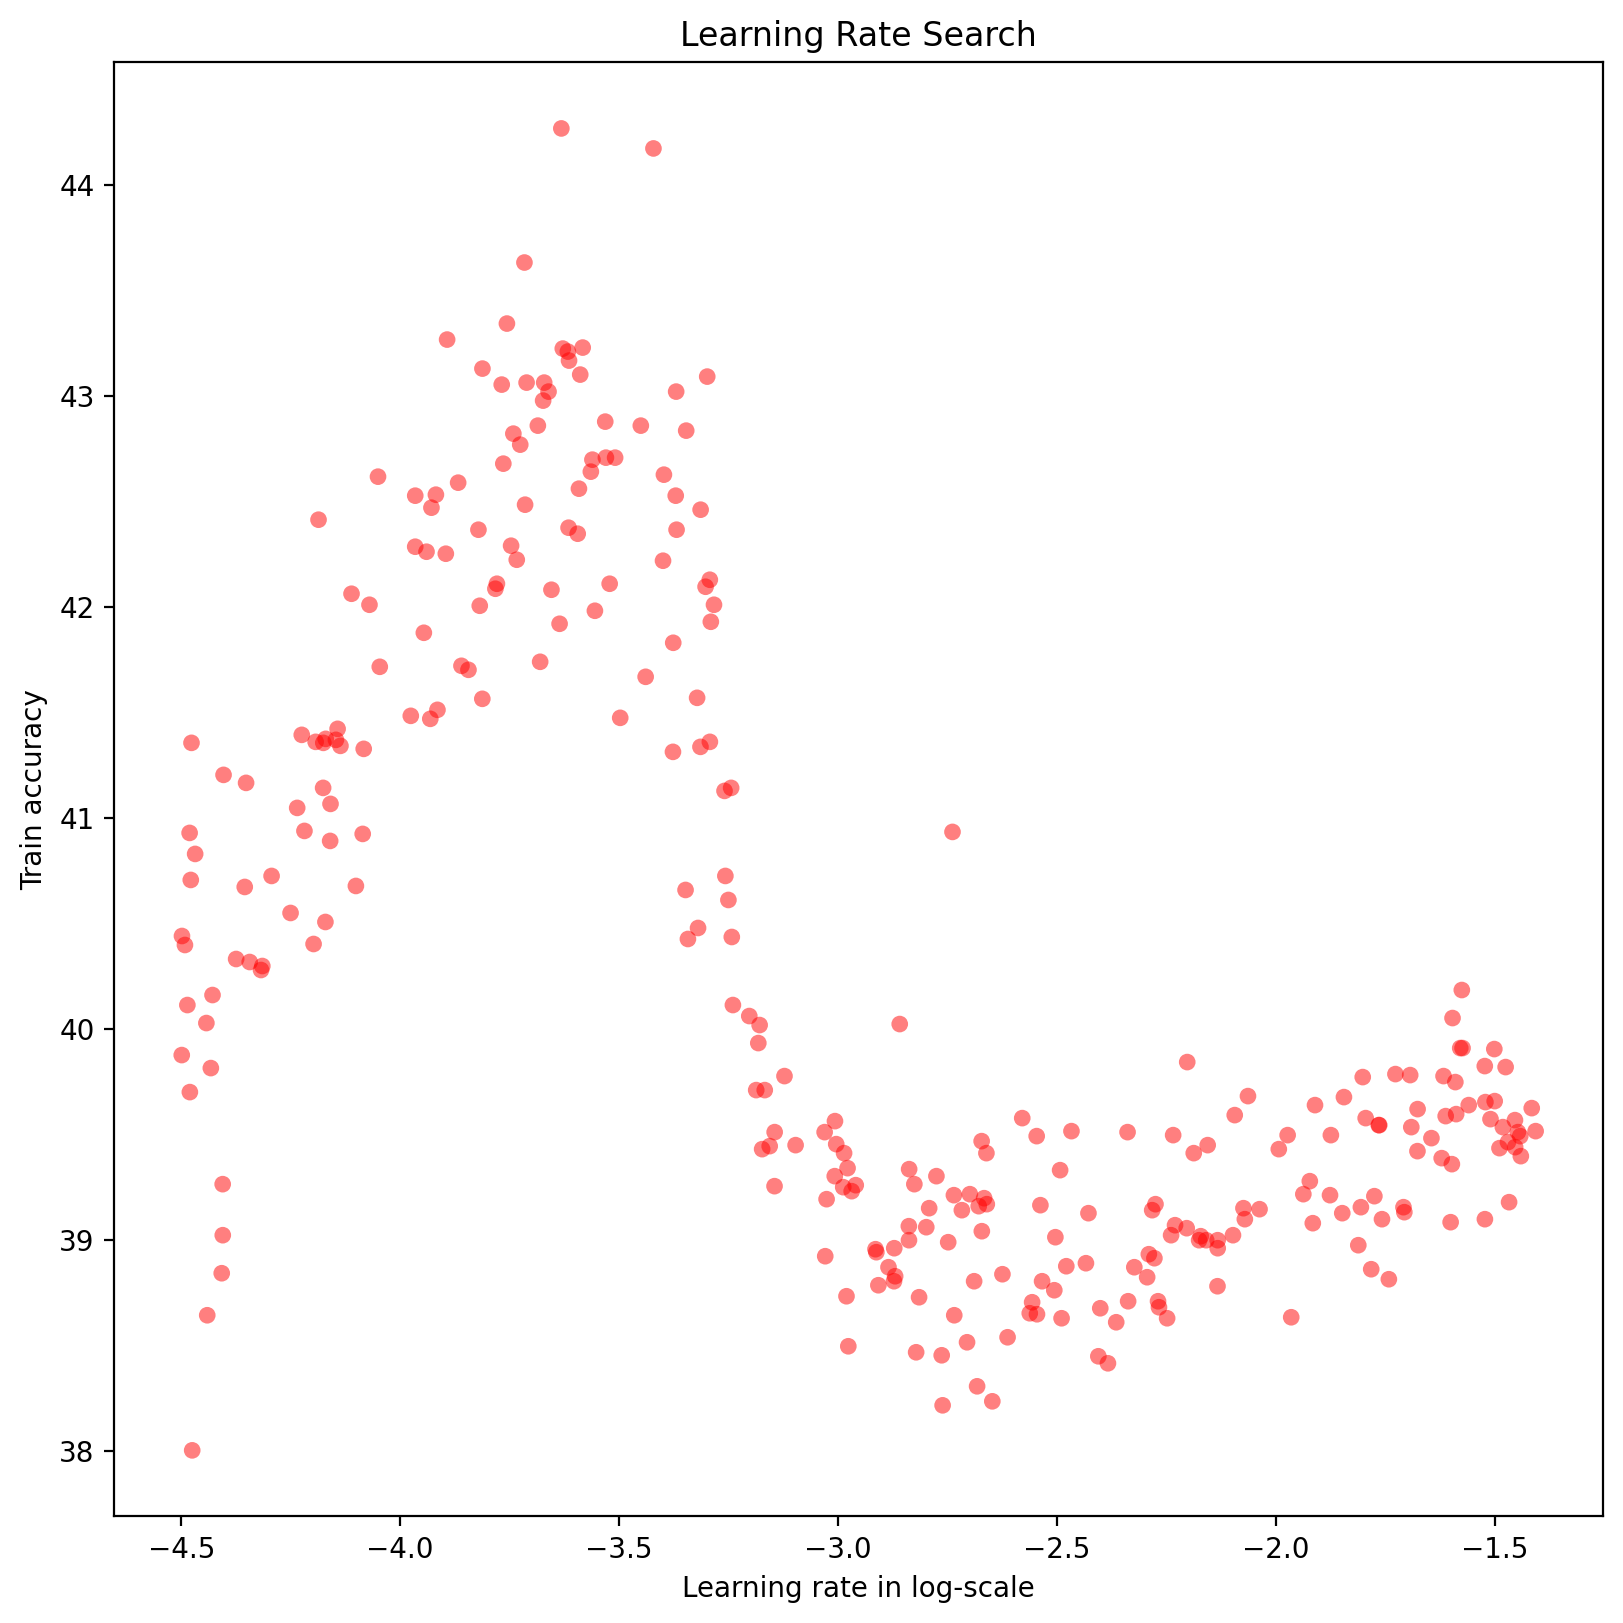

best_log_lr: -3.632039123156609


In [33]:
record = learning_rate_search(model, 
                              min_log_lr=-4.5, 
                              max_log_lr=-1.4, 
                              trials=300, 
                              epochs=1)
draw_learning_rate_record(record)
best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

# best_log_lr = -2.462123346845201
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/200 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 200, Learning rate: 2.33e-04 ------------------------------
- Iter 131 / 659, Loss: 0.979407
- Iter 262 / 659, Loss: 1.073285
- Iter 393 / 659, Loss: 0.837463
- Iter 524 / 659, Loss: 0.994550
- Iter 655 / 659, Loss: 1.104295

* Train accuracy / confusion: 44.27% / [[6106, 2001, 437], [4286, 2445, 757], [2407, 1864, 785]], 
* Val   accuracy / confusion: 48.26% / [[891, 139, 39], [577, 204, 157], [259, 195, 179]]

------------------------------ Epoch 002 / 200, Learning rate: 2.33e-04 ------------------------------
- Iter 131 / 659, Loss: 0.985477
- Iter 262 / 659, Loss: 1.024757
- Iter 393 / 659, Loss: 0.918285
- Iter 524 / 659, Loss: 1.017798
- Iter 655 / 659, Loss: 0.857282

* Train accuracy / confusion: 50.49% / [[6303, 1681, 565], [3511, 2461, 1518], [1367, 1798, 1884]], 
* Val   accuracy / confusion: 43.90% / [[503, 216, 350], [189, 177, 572], [80, 74, 479]]

------------------------------ Epoch 003 / 200, Learning rate: 2.33e-04 ---------

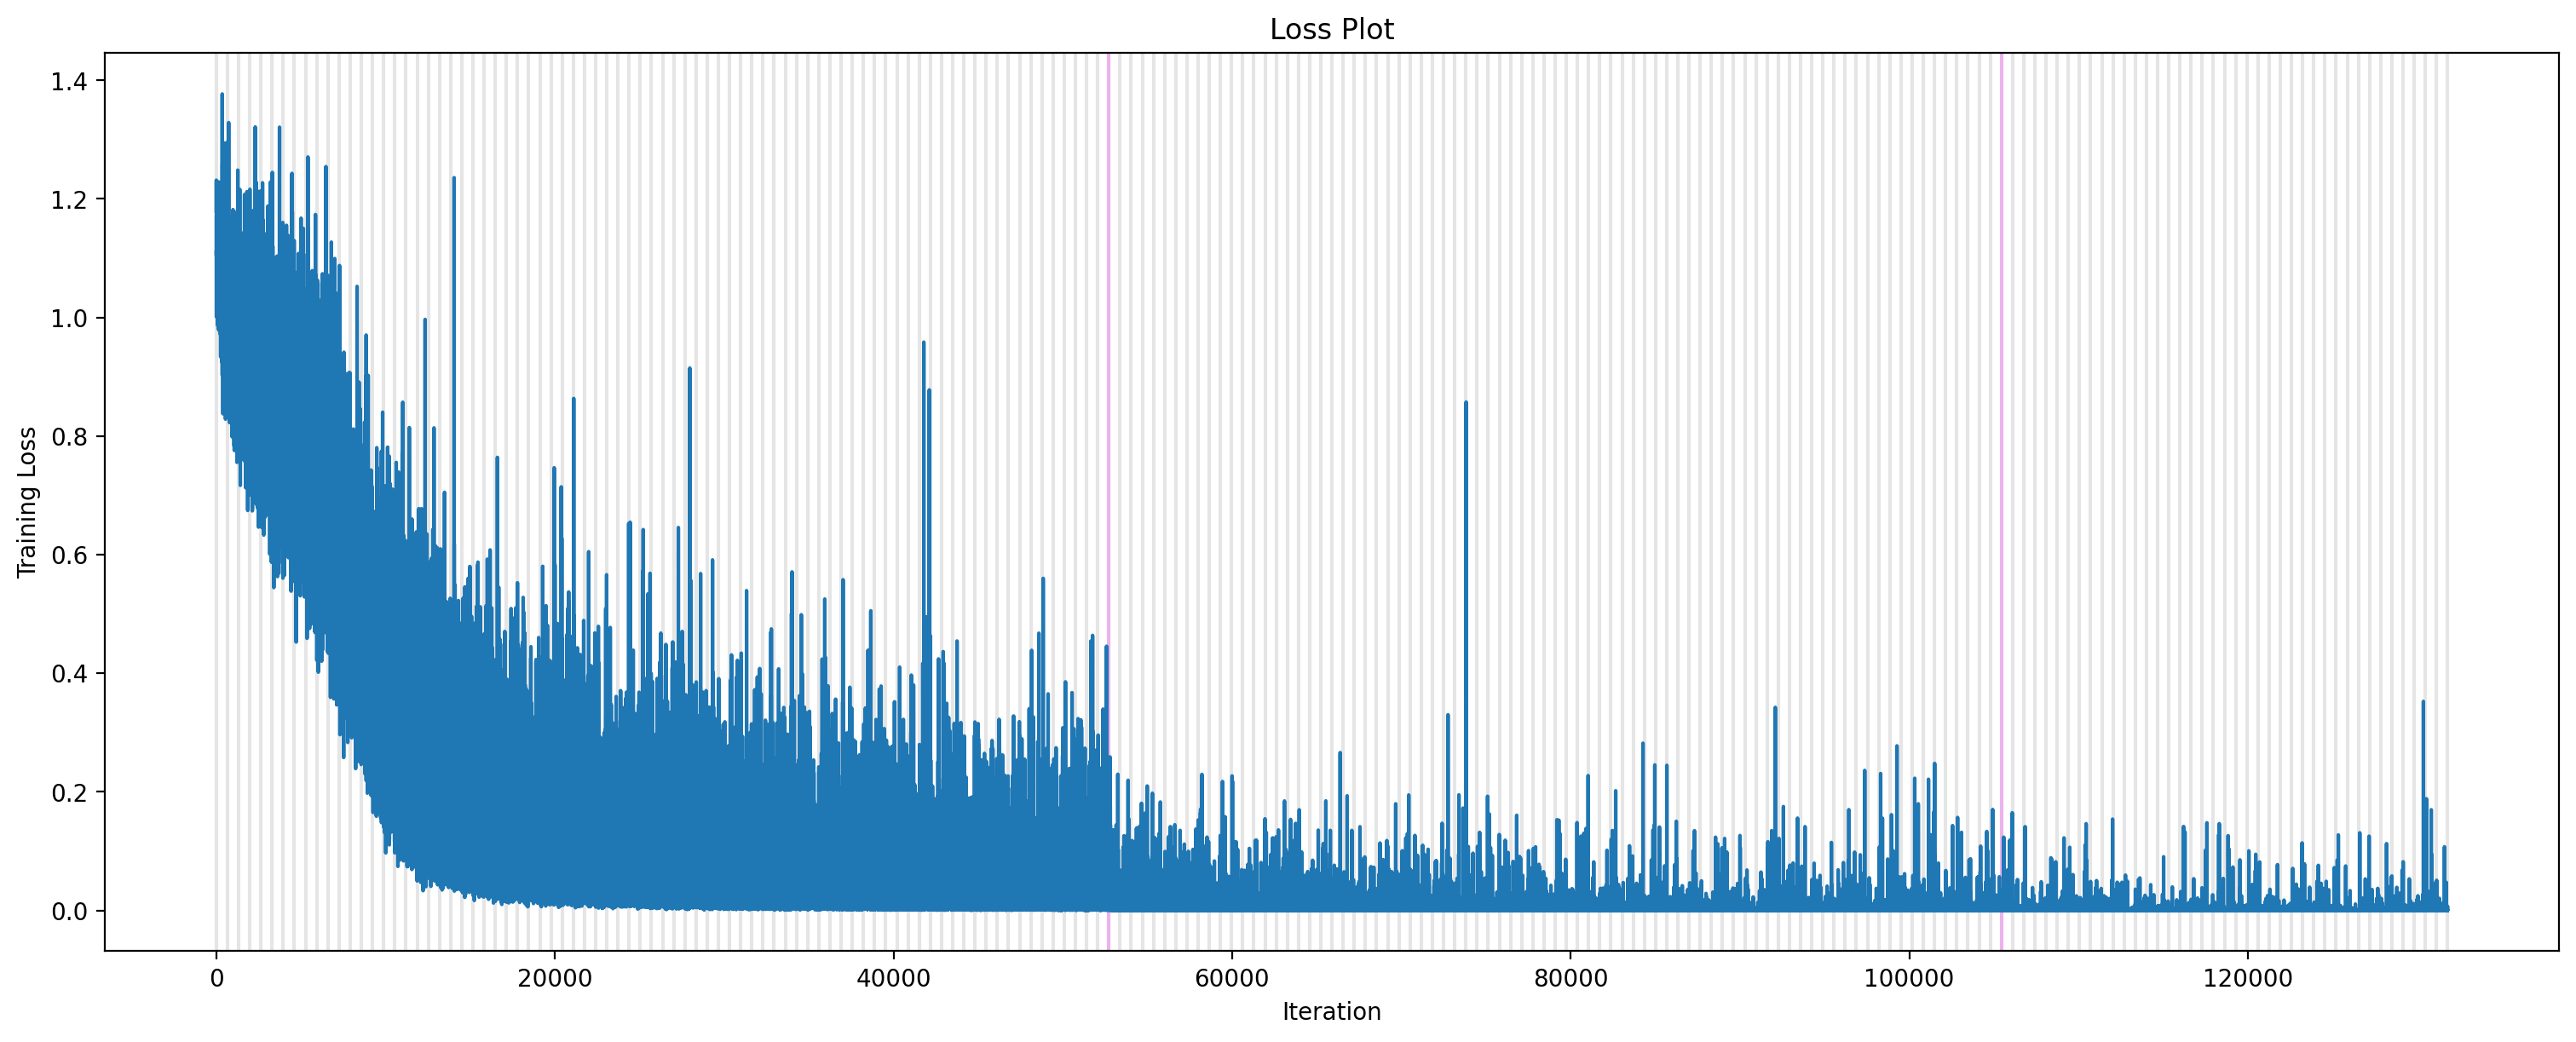

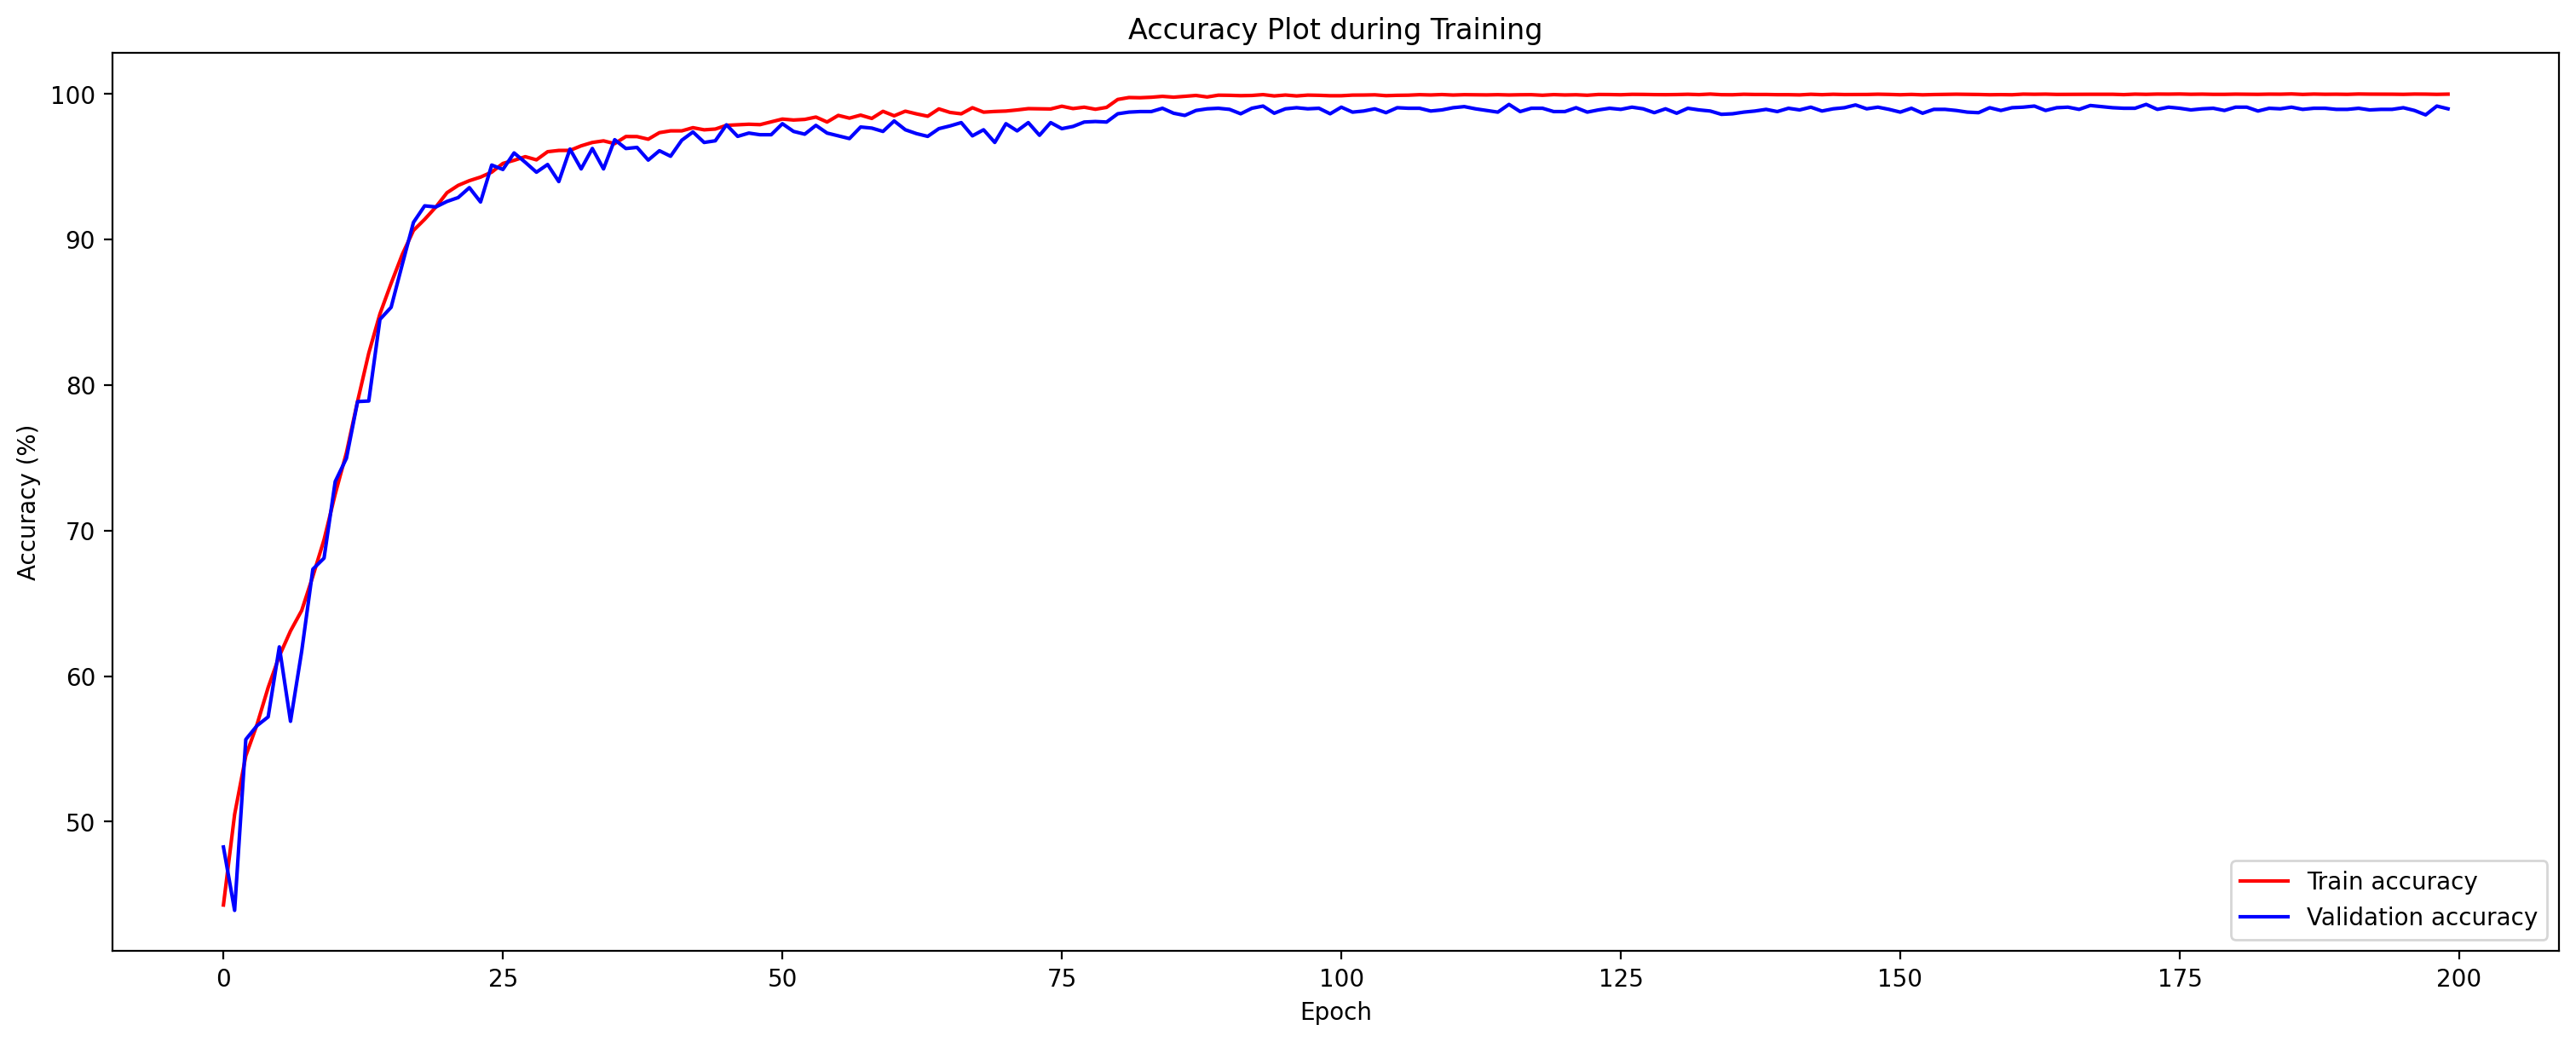

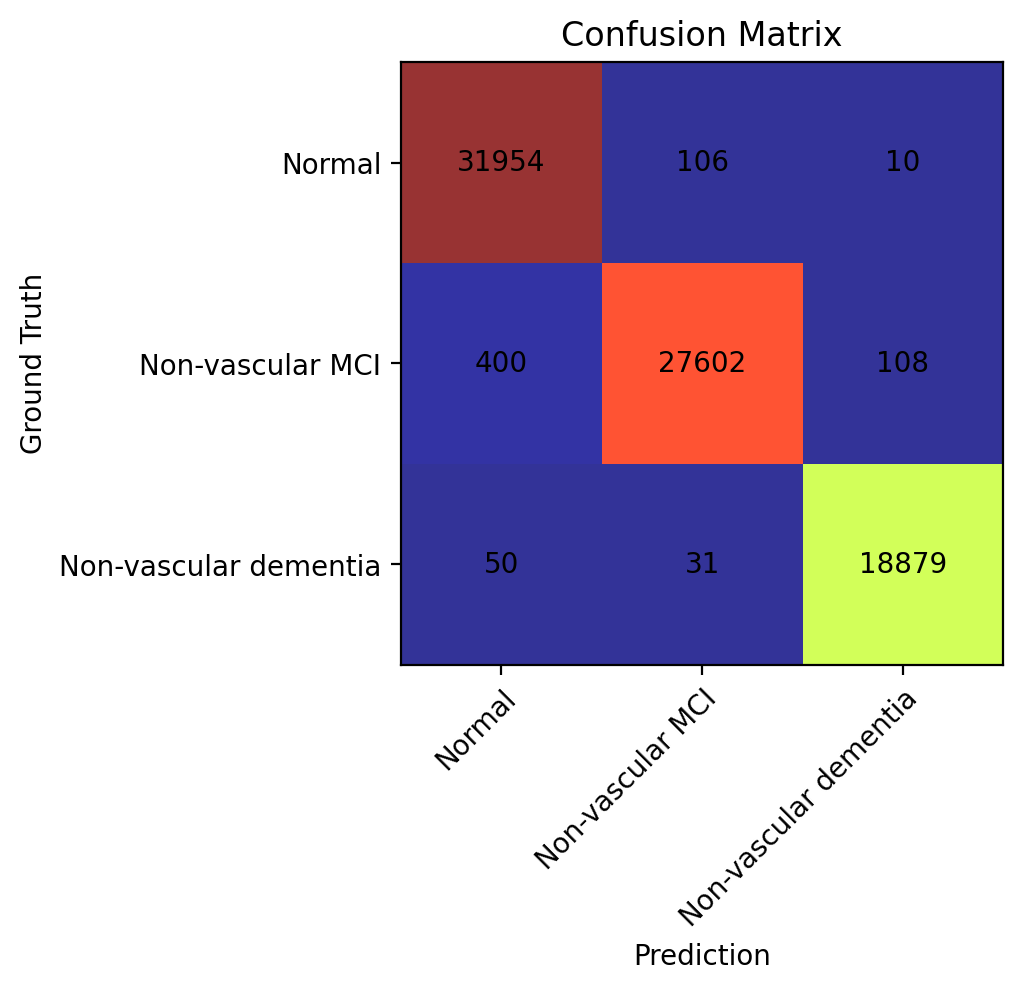

In [34]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 200
lr_schedule_step = 80
log_interval = len(train_loader) // 5

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [35]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

- Debug table:
{ '14546': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00865039_170816'},
  '00719': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00164098_041214'},
  '30664': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01303196_020317'},
  '04086': {'GT': 0, 'Acc': '100.00%', 'Pred': [30, 0, 0], 'edfname': '00498791_260916'},
  '05765': {'GT': 2, 'Acc': '100.00%', 'Pred': [0, 0, 30], 'edfname': '00623681_070415'},
  '19208': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01008809_021017'},
  '19516': {'GT': 2, 'Acc': '100.00%', 'Pred': [0, 0, 30], 'edfname': '01019016_241115'},
  '36174': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01430323_060819'},
  '12726': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00796686_020819'},
  '31736': {'GT': 0, 'Acc': '100.00%', 'Pred': [30, 0, 0], 'edfname': '01324136_201217'},
  '07979': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00673505_02041

#### Small ResNet-like Model

In [22]:
model = ResNet(block=BasicResBlock, conv_layers=[1, 1, 1, 1], n_fc=3, 
               n_input=train_dataset[0]['signal'].shape[0], n_output=3, n_start=64,
               kernel_size=9, use_age=False)
model = model.to(device, dtype=torch.float32)
print(model)
print()

n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_stage1): Sequential(
    (0): BasicResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage2): Sequential(
    (0): BasicResBlock(
      (conv1): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

  0%|          | 0/300 [00:00<?, ?it/s]

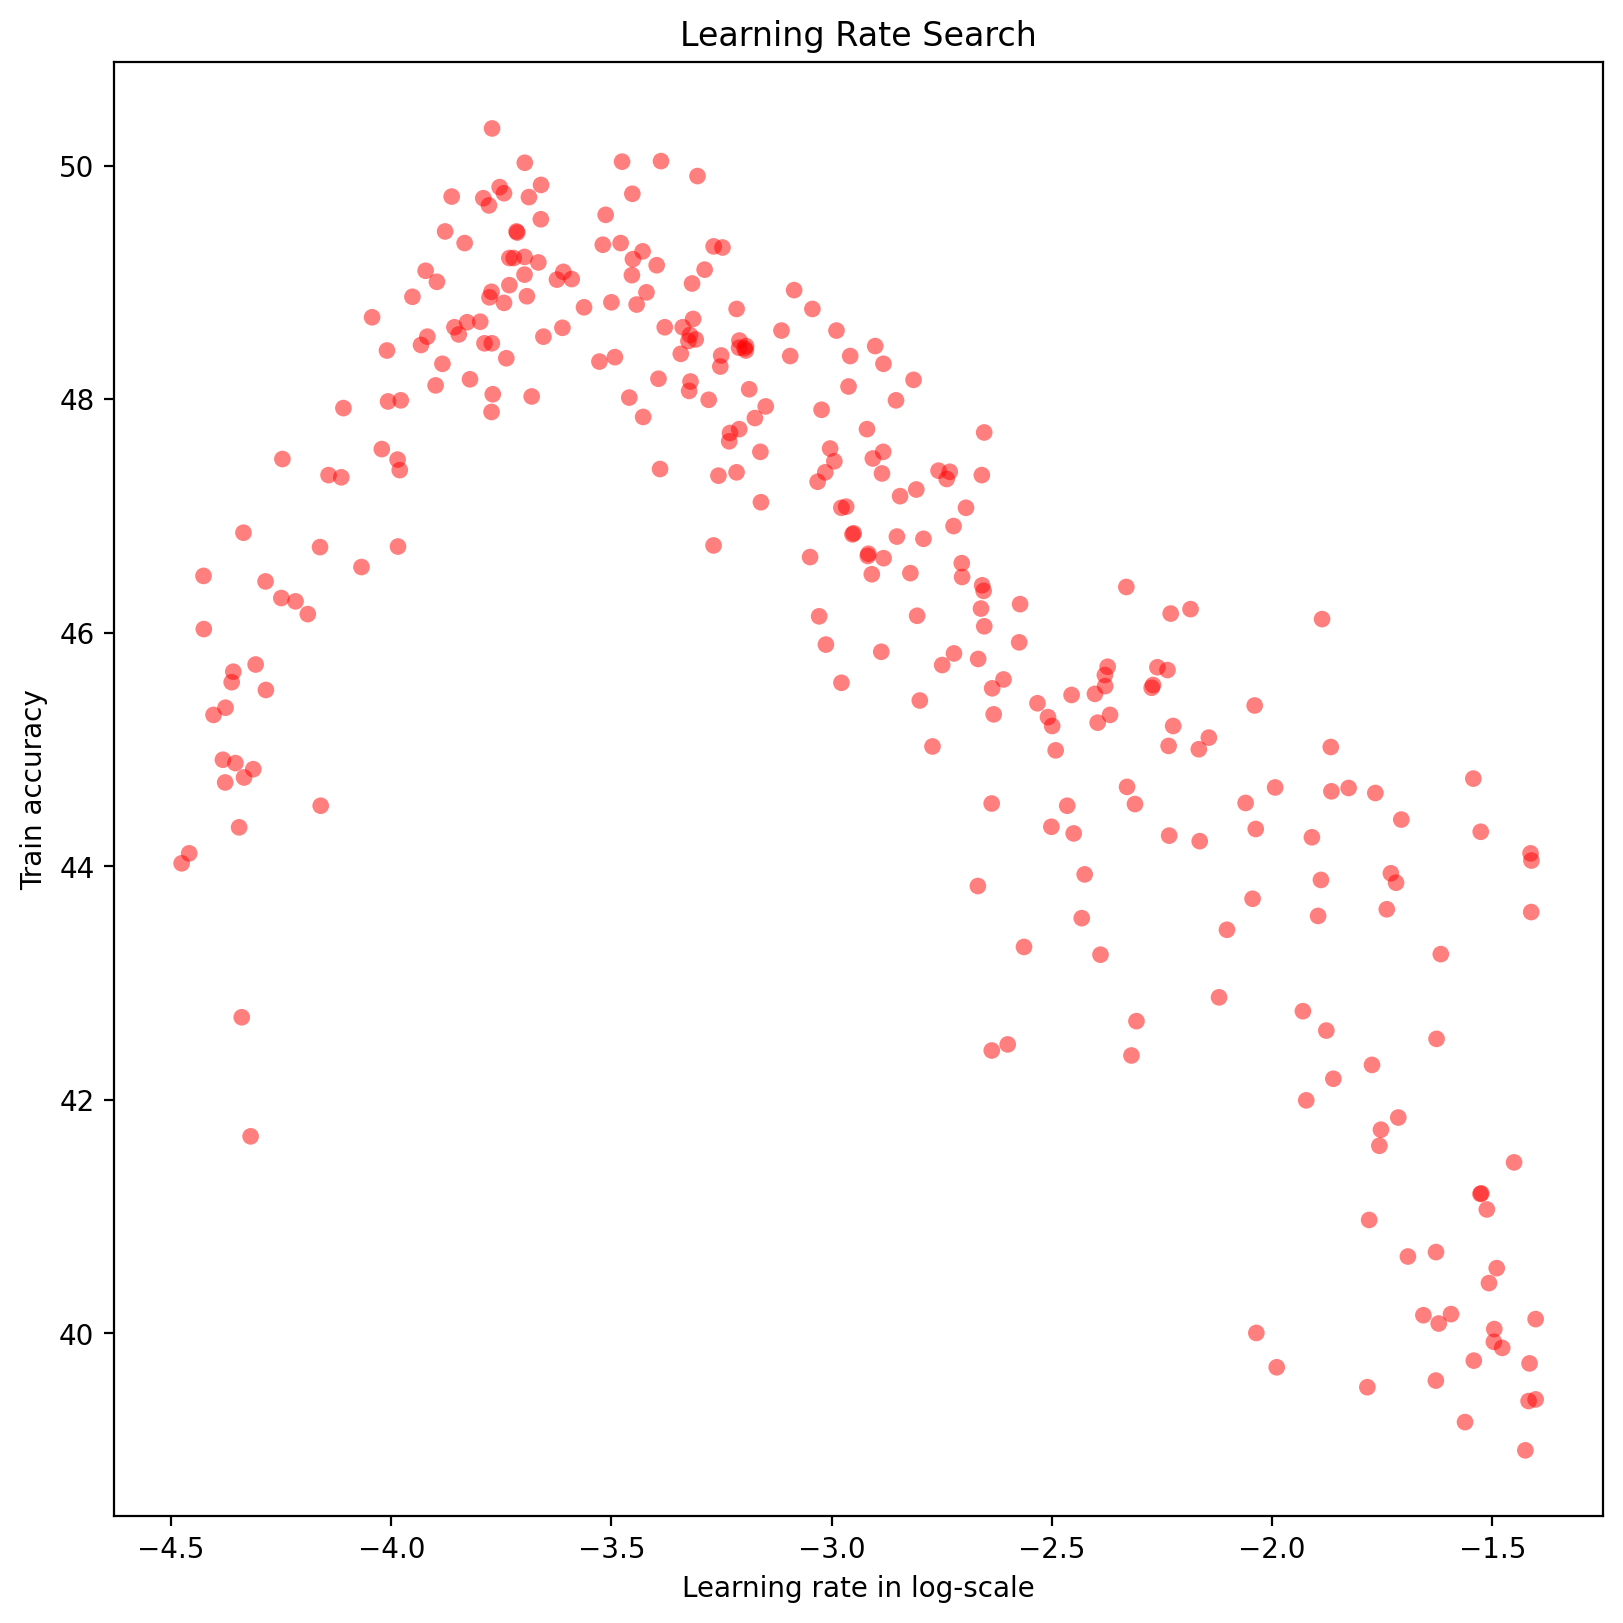

best_log_lr: -3.771206416907112


In [37]:
record = learning_rate_search(model, 
                              min_log_lr=-4.5, 
                              max_log_lr=-1.4, 
                              trials=300, 
                              epochs=1)
draw_learning_rate_record(record)
best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

# best_log_lr = -2.3
print('best_log_lr:', best_log_lr)

**************************************** Training Starts ****************************************


  0%|          | 0/200 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 200, Learning rate: 1.69e-04 ------------------------------


C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


- Iter 131 / 659, Loss: 1.055253
- Iter 262 / 659, Loss: 1.142249
- Iter 393 / 659, Loss: 0.963515
- Iter 524 / 659, Loss: 0.953288
- Iter 655 / 659, Loss: 1.032606

* Train accuracy / confusion: 48.23% / [[5544, 2234, 762], [3205, 2992, 1292], [1592, 1833, 1634]], 
* Val   accuracy / confusion: 54.24% / [[676, 306, 87], [266, 480, 192], [102, 255, 276]]

------------------------------ Epoch 002 / 200, Learning rate: 1.69e-04 ------------------------------
- Iter 131 / 659, Loss: 0.906685
- Iter 262 / 659, Loss: 0.824988
- Iter 393 / 659, Loss: 1.027421
- Iter 524 / 659, Loss: 0.833090
- Iter 655 / 659, Loss: 0.724007

* Train accuracy / confusion: 56.25% / [[6075, 1865, 600], [2723, 3353, 1415], [1059, 1563, 2435]], 
* Val   accuracy / confusion: 54.92% / [[535, 483, 51], [137, 678, 123], [53, 343, 237]]

------------------------------ Epoch 003 / 200, Learning rate: 1.69e-04 ------------------------------
- Iter 131 / 659, Loss: 0.723190
- Iter 262 / 659, Loss: 1.019172
- Iter 393 / 

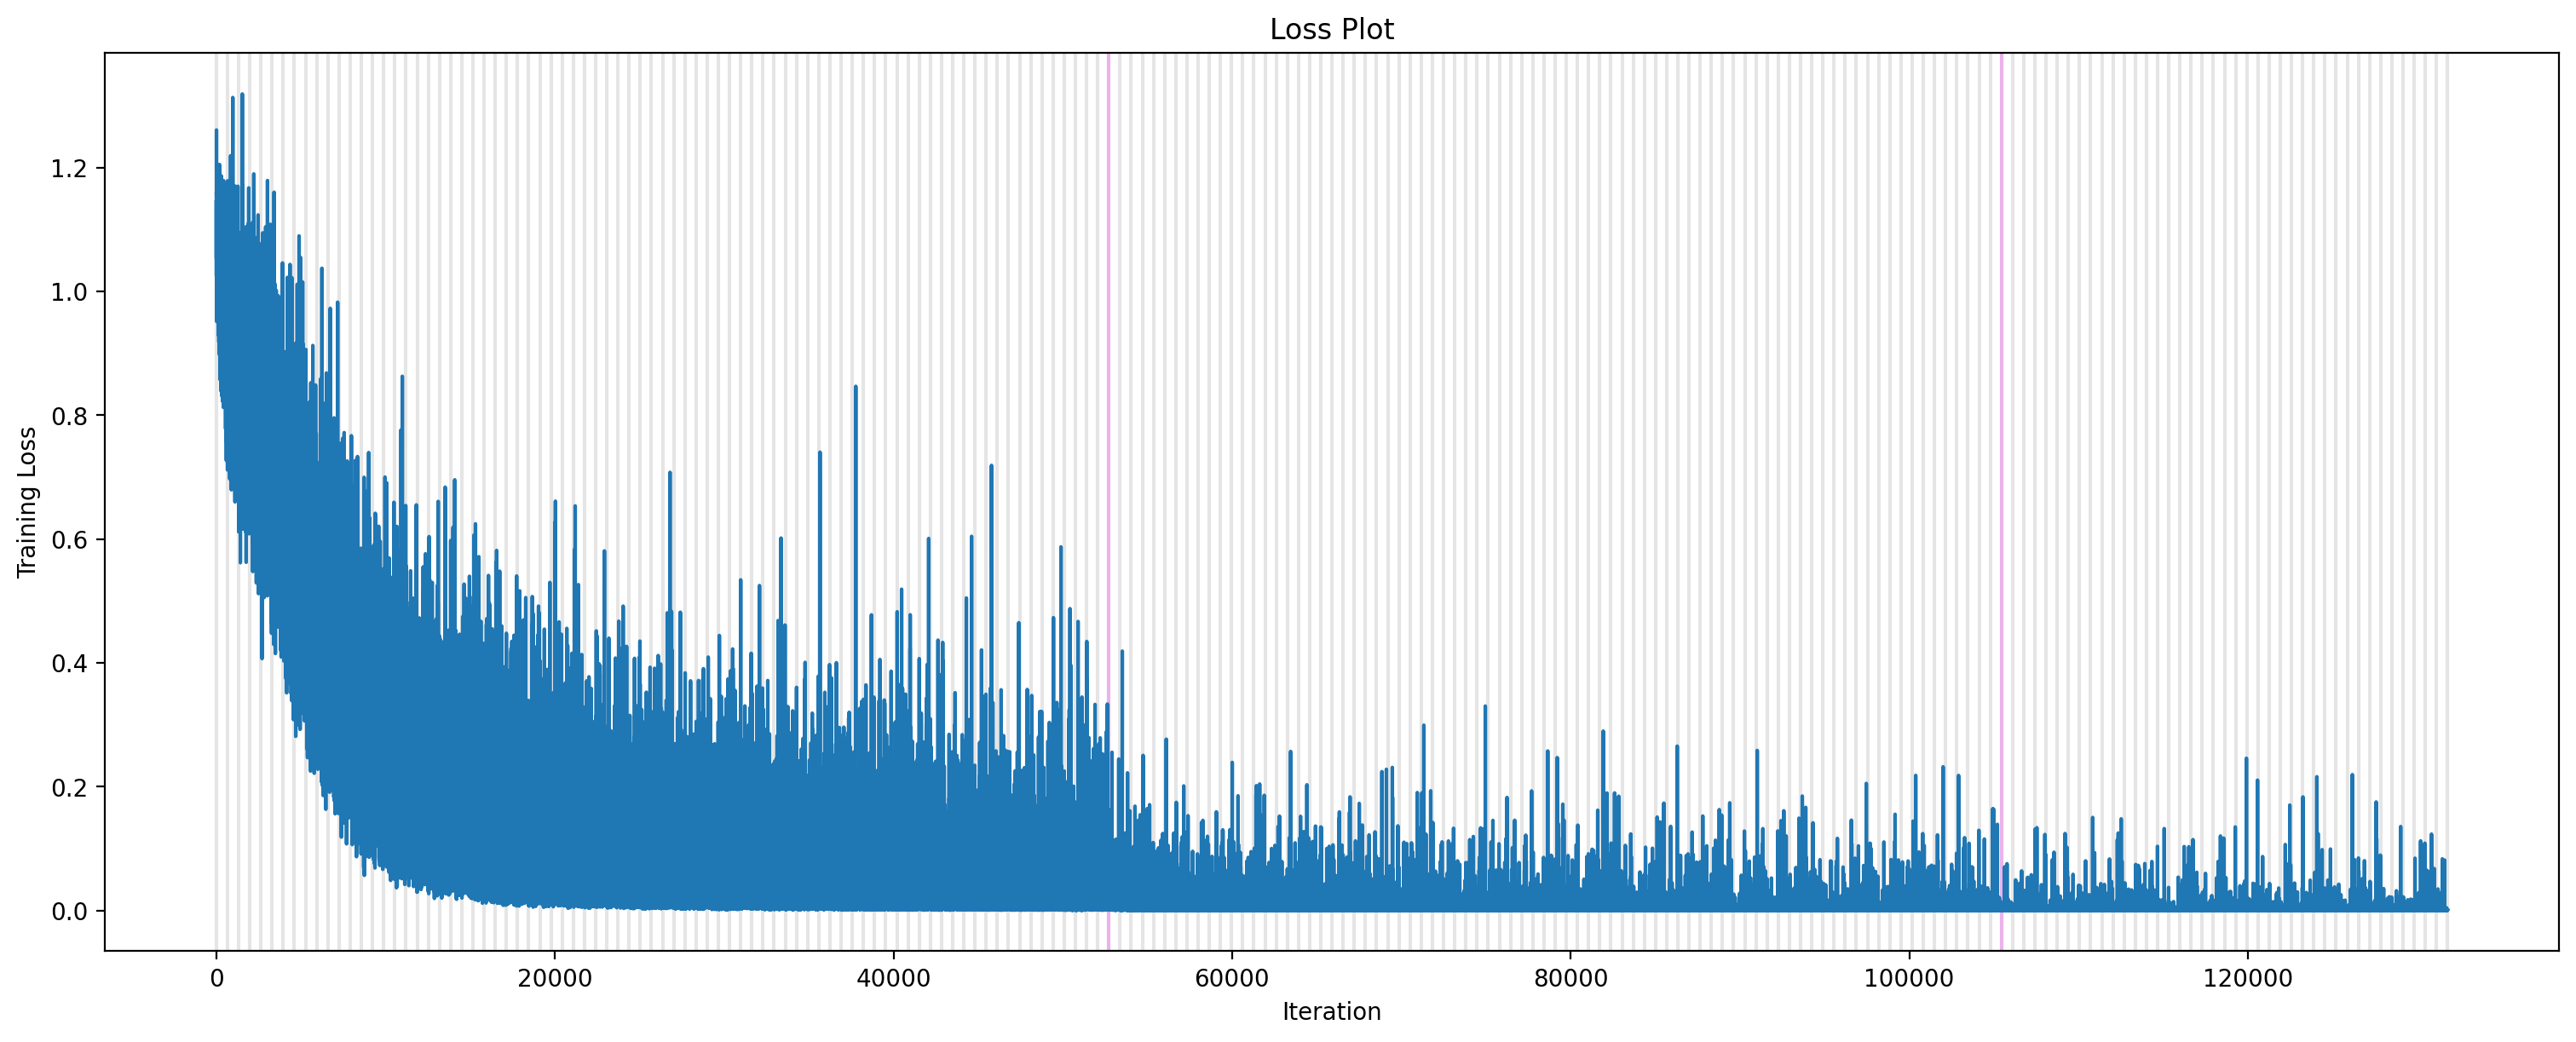

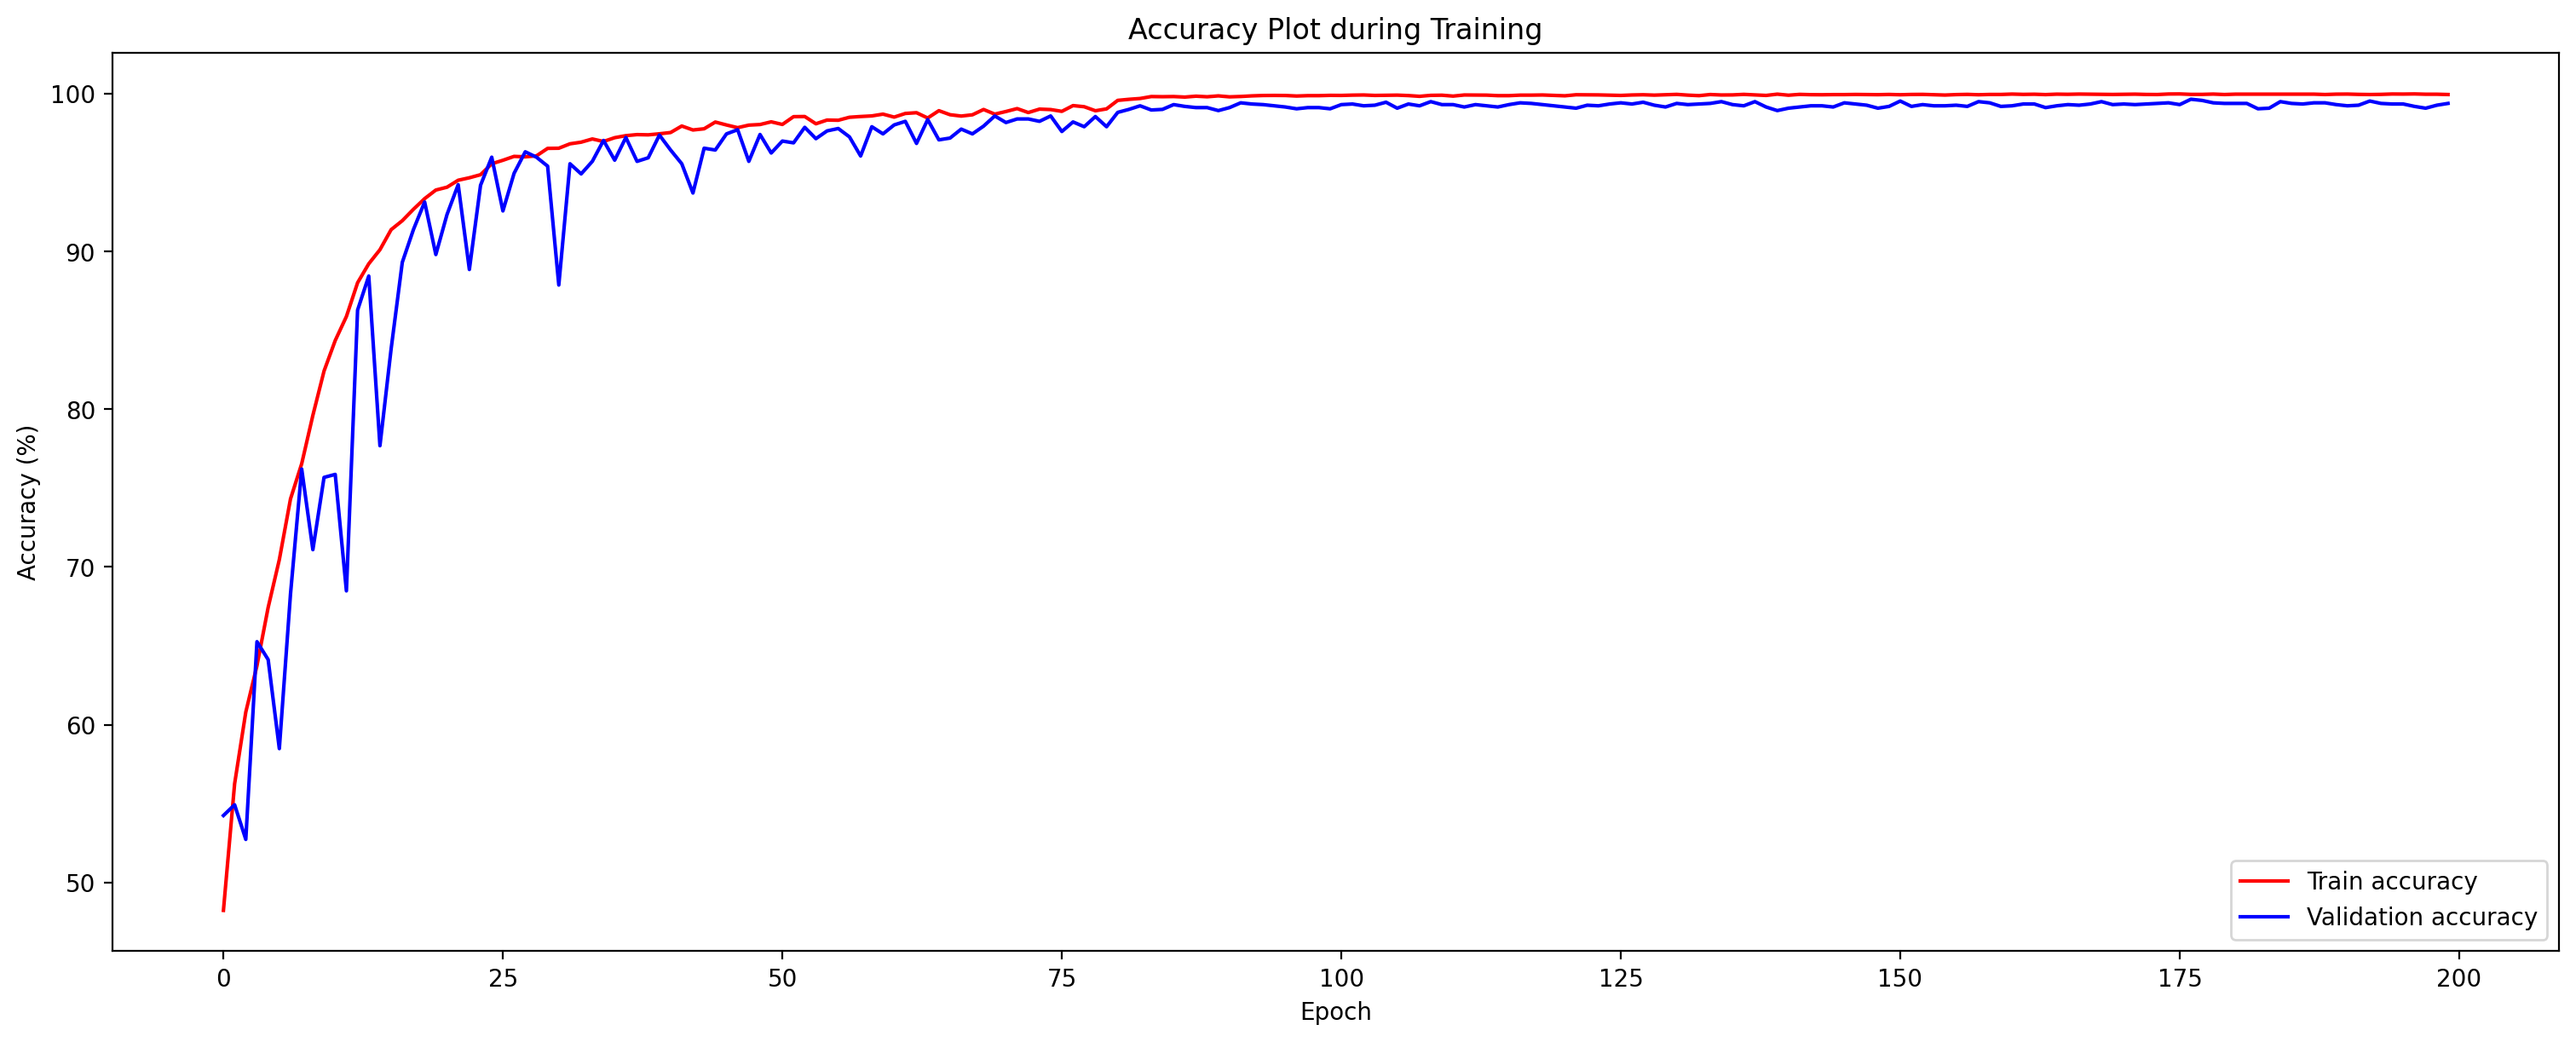

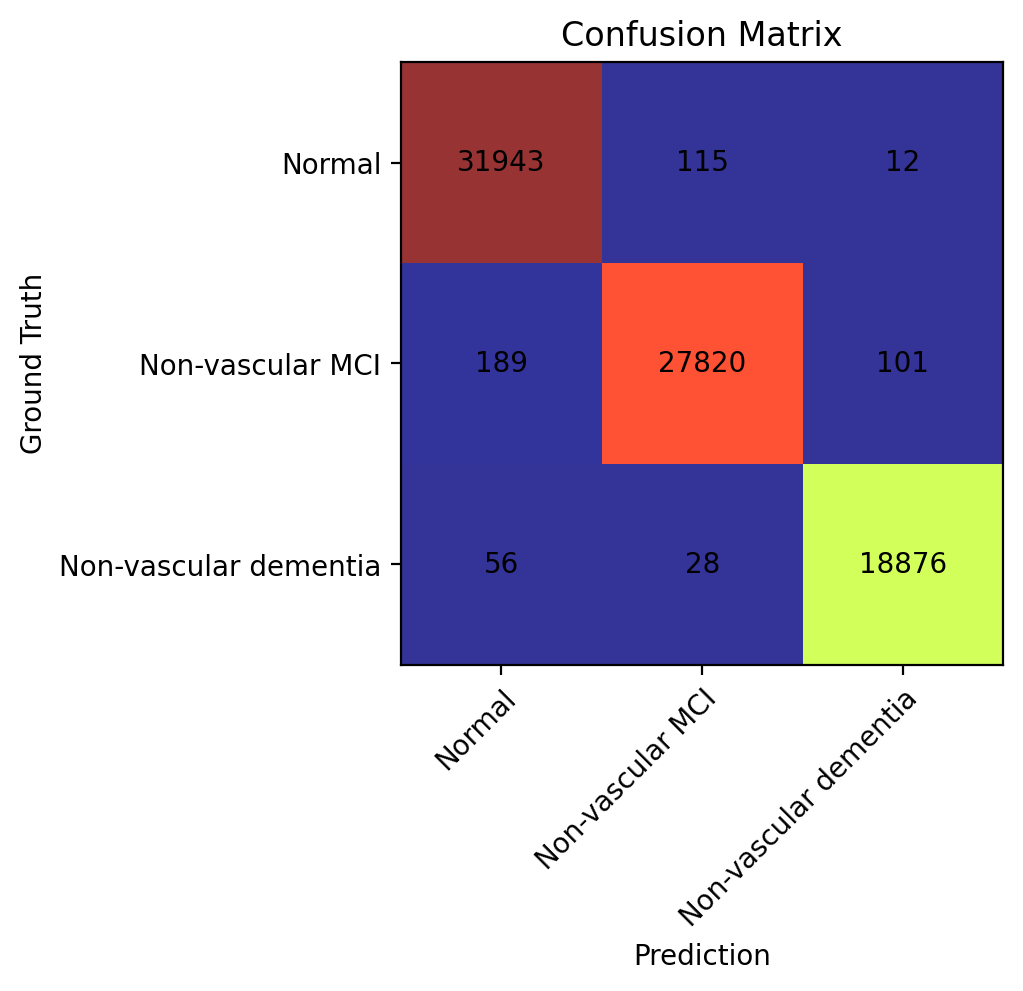

In [23]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 200
lr_schedule_step = 80
log_interval = len(train_loader) // 5

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [24]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

- Debug table:
{ '14546': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00865039_170816'},
  '00719': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00164098_041214'},
  '30664': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01303196_020317'},
  '04086': {'GT': 0, 'Acc': '100.00%', 'Pred': [30, 0, 0], 'edfname': '00498791_260916'},
  '05765': {'GT': 2, 'Acc': '100.00%', 'Pred': [0, 0, 30], 'edfname': '00623681_070415'},
  '19208': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01008809_021017'},
  '19516': {'GT': 2, 'Acc': '100.00%', 'Pred': [0, 0, 30], 'edfname': '01019016_241115'},
  '36174': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '01430323_060819'},
  '12726': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00796686_020819'},
  '31736': {'GT': 0, 'Acc': '100.00%', 'Pred': [30, 0, 0], 'edfname': '01324136_201217'},
  '07979': {'GT': 1, 'Acc': '100.00%', 'Pred': [0, 30, 0], 'edfname': '00673505_02041

In [25]:
os.makedirs('checkpoint/', exist_ok=True)
today = datetime.date.today()
torch.save(model, f'checkpoint/{today.year % 100}{today.month:02d}{today.day}_{nb_fname}_ResNet50_last')